# <center> <font size="20"> -- Course Project Part 2 -- </font> </center>



<br/>

## <font size="20"> &#8681; </font> **Import**

- Import all packages required for Part 1 & 2

In [116]:
# import
#--------------------------------------------------#
import os 
import sys
import os.path
from sys import platform
from pathlib import Path
#--------------------------------------------------#
import re
import sys
import time
import copy
import math
import html
import scipy
import pickle
import random
import argparse
import subprocess
import numpy as np
import pandas as pd

#--------------------------------------------------#
from xgboost import XGBClassifier
#--------------------------------------------------#
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#--------------------------------------------------#
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
#--------------------------------------------------#
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#--------------------------------------------------#
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
#--------------------------------------------------#
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
#--------------------------------------------------#
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
#--------------------------------------------------#

# Vader
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#--------------------------------------------------#
import warnings
warnings.filterwarnings("ignore")
#--------------------------------------------------#
from typing import Optional, Union, Tuple, Type, Sequence, List, Set, Dict, Any, TextIO, IO




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\cesiu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!




<br/>

## <font size="20"> &#8681; </font> Deal with different environments. 
- Make sure the notebook runs properly in different environments.

In [117]:
#====================================================================================================#
# Install google-related packages. 

# !pip install google-colab
# !pip install --upgrade google-cloud
# !pip install --upgrade google-cloud-vision
# !pip install --upgrade google-api-python-client

#====================================================================================================#
# Identify if the env is google colab.
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB == True:
    from google.colab import drive
    drive.mount('/content/gdrive')
    file_1      = '/content/gdrive/MyDrive/sentiment_analysis.csv' 
    data_file   = '/content/gdrive/MyDrive/sentiment_analysis.csv' 
    data_folder = Path("./")




<br/>
<br/>

## &#10148; Load data and model from **Part 1**
- The following several blocks contain code mostly from **Part 1**.
- Dataset from Part 1 will be used to load the vectorizer and feature selector.
- Model from Part 1 will be loaded to predict sentiment labels for datasets in Part 2. 



<br/>

## <font size="20"> &#8681; </font> Load and clean the original dataset.
In this block, 
- Data is loaded into the notebook as a dataframe. 
- A function is defined to print out more details of the dataset. 
- Print out the dataframe. 

In [118]:
#====================================================================================================#
# Load data
data_folder = Path("./data_folder")
data_file   = "sentiment_analysis.csv"

#====================================================================================================#
# For clearly print a dataframe. 
def beautiful_print(df): # Print the DataFrame obtained (May NOT work properly in jupyter notebook).
    # Print the dataset in a well-organized format.
    with pd.option_context('display.max_rows'       , 10   , 
                           'display.min_rows'       , 10   , 
                           'display.max_columns'    , 15   , 
                           "display.max_colwidth"   , 120 ,
                           "display.width"          , None ,
                           "expand_frame_repr"      , True ,
                           "max_seq_items"          , None , ):  # more options can be specified
        # Once the display.max_rows is exceeded, 
        # the display.min_rows options determines 
        # how many rows are shown in the truncated repr.
        print(df)
    return 

#====================================================================================================#
# Load data with "ISO-8859-1" encoding.
df_raw = pd.read_csv(filepath_or_buffer   =   data_folder/data_file             ,
                     header               =   0                                 , 
                     #index_col           =   0                                 ,
                     encoding             =   "ISO-8859-1"                      ,
                     sep                  =   ','                               ,  
                     low_memory           =   False                             , )

# Print dimension of the raw data.
print("\nRaw dataset printed below: ")
print("df_raw.shape: ", df_raw.shape) # 3 columns. 
#beautiful_print(df_raw)
print(df_raw.head(5))





Raw dataset printed below: 
df_raw.shape:  (550391, 3)
             ID                                               text  label
0  7.680980e+17  Josh Jenkins is looking forward to TAB Breeder...      1
1  7.680980e+17  RT @MianUsmanJaved: Congratulations Pakistan o...      1
2  7.680980e+17  RT @PEPalerts: This September, @YESmag is taki...      1
3  7.680980e+17  RT @david_gaibis: Newly painted walls, thanks ...      1
4  7.680980e+17  RT @CedricFeschotte: Excited to announce: as o...      1


<br/>

## <font size="20"> &#8681; </font> Define a list of functions for cleaning and preprocessing the text data
The list of functions will be implemented to, (in the following order)
- Preprocess (commonly done to text data) 
    - Remove whitespace
    - Unescape html and replace html character codes with ascii equivalent
    - Remove URLs.
    - Remove duplicate spaces.
    - Remove html tags, user tags
- Identify language and screen English comments
- Clean text
    - Remove HTML tags
    - Remove user tags
    - Remove URLs
    - Remove non-alphanumeric characters
    - Remove "#" in Hashtags
    - Remove Retweet
    - Remove unicode
    - Remove non-ASCII chars (for test only)


In [119]:
# A list of functions for clean the text data

#====================================================================================================#
# Extra Options for preprocessing text data.
def clean_text_preproc(text):
    # List of extra functions for dealing with raw text. 
    #--------------------------------------------------#
    # (1) Replace newlines with spaces.
    def remove_whitespace(s):
        return re.sub(r"\n{1,}|\\n{1,}|\r{1,}|\\r{1,}|\t{1,}|\\t{1,}", " ", s)
    # (2) Unescape html and replace html character codes with ascii equivalent.
    def unescape_html(s):
        return html.unescape(s)
    # (3) remove URLs.
    def remove_urls(s):
        return re.sub(r"\b(http:\/\/|https:\/\/|www\.)\S+", "", s)
    # (4) remove duplicate spaces.
    def remove_duplicate_spaces(s):
        return re.sub(r" {2,}", " ", s)
    # (5) 
    def remove_tags(text):
        text = re.sub(r'@[A-Za-z0-9_:]+', '', text)  
        text = re.sub(r'#(\S+)', r'\1', text)        
        text = re.sub(r'^RT ', '', text)             
        return text
    #--------------------------------------------------#
    text = remove_whitespace       (text)
    text = unescape_html           (text)
    text = remove_urls             (text)
    text = remove_duplicate_spaces (text)
    text = remove_tags             (text)
    return text

#====================================================================================================#
# Remove unicode characters from the string.
def remove_unicode(str_x):
    return str_x.encode("ascii", "ignore").decode()

#====================================================================================================#
# Clean the data for Language Models (For Later Use.)
def clean_text_LM(text):
    text = re.sub(r'<.*?>', '', text)                    # Remove HTML tags
    text = re.sub(r'@[A-Za-z0-9_:]+', '', text)          # Remove User tags
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)  # Remove URLs
    #text = re.sub(r'[^A-Za-z0-9 ]+', '', text)          # Remove non-alphanumeric characters
    text = re.sub(r'#(\S+)', r'\1', text)                # Remove "#" in Hashtags.
    text = re.sub(r'^RT ', '', text)                     # Remove Retweet

    def replacer(match):
        if match.group(1) is not None:
            return '{} '.format(match.group(1))
        else:
            return ' {}'.format(match.group(2))

    rx = re.compile(r'^(\W+)|(\W+)$')
    text = " ".join([rx.sub(replacer, word) for word in text.split()])
    return remove_unicode(text.strip()).lower()

#====================================================================================================#
# Clean the data for Sentiment Classifer to be trained.
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)                    # Remove HTML tags
    text = re.sub(r'@[A-Za-z0-9_:]+', '', text)          # Remove user tags
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)           # Remove non-alphanumeric characters
    text = re.sub(r'#(\S+)', r'\1', text)                # Remove "#" in Hashtags.
    text = re.sub(r'^RT ', '', text)                     # Remove Retweet
    return remove_unicode(text.strip()).lower()

#====================================================================================================#
# Check the string is fully ASCII chars or not. (for test use only)
def is_ASCII_only_string(s):
    return not bool(re.search('[^\x00-\x7F]+', s))

#====================================================================================================#
# Check the string is English or NOT. (using the ``spaCy`` package)
# Can also use `TextBlob` or `Pycld2` but I dont want to use google API.
print("\n``spaCy`` is used to detect language. Need to, \n(1)install ``spaCy`` \n(2)Download models via")
print("    python -m spacy download en_core_web_lg")
print("    python -m spacy download en_core_web_sm")
# !pip install spacy
# !pip install spacy_langdetect
# !python -m spacy download en_core_web_lg
# !python -m spacy download en_core_web_sm
# !python -m spacy download en_core_web_trf
#--------------------------------------------------#
# Prepares
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector
nlp = spacy.load("en_core_web_lg")
def get_lang_detector(nlp, name):
    return LanguageDetector()
# Language Factory cannot be loaded multiple times for no reason.
# Therefore, have to use try/except block.
try:
    Language.factory("language_detector", func = get_lang_detector)
except:
    pass
nlp.add_pipe('language_detector', last = True)
#--------------------------------------------------#
# Define a function for identifying language (whether English).
def is_English(text_str):
    doc = nlp(text_str)
    detect_language = doc._.language["language"] 
    score           = doc._.language["score"]
    return (detect_language == "en"), detect_language, score

def is_English_batch_process(text_list):
    ifEnglish_list = []
    dtct_lang_list = []
    score_list = []
    for idx, doc in enumerate(nlp.pipe(text_list, n_process = 4, batch_size = 2000)):
        lang_detect_result  =  doc._.language
        detect_language     =  lang_detect_result["language"] 
        score               =  lang_detect_result["score"]
        ifEnglish_list.append(detect_language == "en")
        dtct_lang_list.append(detect_language)
        score_list    .append(score)
    return ifEnglish_list, dtct_lang_list, score_list


# All-Caps Text will be detected as German.
# Very short text will be detected as random language. 
# print(is_English(  "Some English Text are often FALSEly identified" ))
# print(is_English(  "happy birthday"                                 ))  
# print(is_English(  "happy birthday to you my little sweetie"        ))
# print(is_English(  "Le client est très important merci"             ))
# print(is_English(  "WHAT FUCKING LANGUAGE IS MY FUCKING PHONE IN"   ))   


``spaCy`` is used to detect language. Need to, 
(1)install ``spaCy`` 
(2)Download models via
    python -m spacy download en_core_web_lg
    python -m spacy download en_core_web_sm




<br/>

## <font size="20"> &#8681; </font> Use the functions defined previously to clean the data.

- Use previously defined functions to clean the text. 
- Among the ~550k labeled text data, 99.9%+ are English.
- Some text are falsely identified as non-English language due to various reasons listed below.
    - super short text
    - all-caps text
    - spelling mistakes (some are on purpose)
    - using words from other languages
- Most of the data are English. The dataset to be analyzed also contains mostly English text.
- Therefore, it is reasonable to remove text (instances) in other languages.
    - Identifying English text use spaCy package.
    - Language detection step takes 50 minutes so results are saved.
    - Language detection results will be loaded if a saving file exists.
- **FINALLY, MOST IMPORTANTLY, DROP DUPLICATES !!!**


In [120]:
# 
#====================================================================================================#
# Get a copy of the raw.
df_cleaned = copy.deepcopy(df_raw)

# Clean.
df_cleaned['cleaned_text'] = df_cleaned['text'].apply(clean_text_preproc).apply(clean_text)
df_cleaned = df_cleaned.drop(columns=["ID", "text"])

#====================================================================================================#
# Identify language.
#   - Use a saved processed dataframe if found in the savings, otherwise generate a new one. 
#   - Takes 45 min on a 5800X CPU.
if os.path.exists("./Saving_Part_1_df_cleaned_0_all.p"):
    df_cleaned_0_all = pd.read_pickle("./Saving_Part_1_df_cleaned_0_all.p")
else:
    df_cleaned_0_all = df_cleaned.copy(deep = True)
    all_text = df_cleaned_0_all["cleaned_text"].values.tolist()
    English_Check_output = is_English_batch_process(all_text)
    df_cleaned_0_all["If_Eng"]   = English_Check_output[0]
    df_cleaned_0_all["Language"] = English_Check_output[1]
    df_cleaned_0_all["Score"]    = English_Check_output[2]
    df_cleaned_0_all.to_pickle("./Saving_Part_1_df_cleaned_0_all.p")

print("\nLanguages identified by spaCy: ")
print("All English text identified as rare languages (that have been checked) are ")
print("confirmed to be FALSEly detected as non-English, but are mostly data with low-quality. ")
print("Whether to remove these data is optional, since the number is negligible. ")
#print(df_cleaned_0_all['Language'].value_counts().head(20))


df_cleaned_0_non_en = df_cleaned_0_all.loc[(df_cleaned_0_all["If_Eng"] == False) & (df_cleaned_0_all["Score"] > 0.999) ]
# print("\nSome text are identified as non-English, ") # Even this returns English text.
# print(df_cleaned_0_non_en.head(5))

df_cleaned['cleaned_text'] = df_cleaned['cleaned_text'].apply(clean_text_preproc)



#====================================================================================================#
# Clean and format the filtered English text data. (DROP DUPLICATES !!)
# Check duplicates
print("\nCheck for duplicates (mostly advertisements): ")
print(df_cleaned['cleaned_text'].value_counts().head(5)) # Lots of duplciates
# DROP DUPLICATES
df_cleaned = df_cleaned.drop_duplicates(subset = ['cleaned_text'], keep = 'first')
# Rearrange.
df_cleaned.insert(len(df_cleaned.columns)-1, "label", df_cleaned.pop('label') ) 

print("\nProcessed dataset printed below: ")
print("df_cleaned.shape: ", df_cleaned.shape) # 298 column
print(df_cleaned.head(5))
print("\nCheck the number of different labels (class distribution): ")
print(df_cleaned['label'].value_counts())

df = copy.deepcopy(df_cleaned) ; del df_cleaned 





Languages identified by spaCy: 
All English text identified as rare languages (that have been checked) are 
confirmed to be FALSEly detected as non-English, but are mostly data with low-quality. 
Whether to remove these data is optional, since the number is negligible. 

Check for duplicates (mostly advertisements): 
found a transponder snailgiants sea monsters and other amazing encounters trecru    9984
found a transponder snailill never forget you local cook sets sail trecru           2108
found a transponder snailkiller rabbits amazing fauna on one winter isle trecru     1786
happy birthday                                                                       858
happy thanksgiving                                                                   640
Name: cleaned_text, dtype: int64

Processed dataset printed below: 
df_cleaned.shape:  (440900, 2)
                                        cleaned_text  label
0  josh jenkins is looking forward to tab breeder...      1
1  congratulatio



<br/>

## <font size="20"> &#8681; </font> Split the cleaned dataset. 

- The cleaned dataset is splitted into training set and test set with 8:2 ratio.

In [121]:
X_data = df['cleaned_text'].values.tolist()
y_data = df['label']       .values.tolist()

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 1624)



<br/>

## <font size="20"> &#8681; </font> MLP Classifier
- Define a general MLP Classifier
    - Using 3-layer FFNN as architecture.
    - Using CrossEntropyLoss as Criterion.
    - Output Heatmap that visualize the confusion matrix.

In [122]:
#====================================================================================================#
# A General-Purpose MLP Classifier
import torch
import torch.optim as optim

from torch import nn
from torch.utils import data

from torch.nn.utils.weight_norm import weight_norm
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

#====================================================================================================#
# Define A MLP Classifier.
class MulticlassClassification(nn.Module):
    def __init__(self, 
                num_feature, 
                num_class,
                hid_1,
                hid_2,
                hid_3,
                drp_r,
                ):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, hid_1)
        self.layer_2 = nn.Linear(hid_1, hid_2)
        self.layer_3 = nn.Linear(hid_2, hid_3)
        self.layer_out = nn.Linear(hid_3, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drp_r)
        self.batchnorm1 = nn.BatchNorm1d(hid_1)
        self.batchnorm2 = nn.BatchNorm1d(hid_2)
        self.batchnorm3 = nn.BatchNorm1d(hid_3)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

#====================================================================================================#
# Define DataLoader and Dataset for the model.
class LoaderClass_LowRAM(Dataset):
    def __init__(self, X_data, y_data):
        super(LoaderClass_LowRAM, self).__init__()
        self.X_data = X_data
        self.y_data = y_data
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    def __len__ (self):
        return len(self.X_data)
    def collate_fn(self, batch:List[Tuple[Any, ...]]) -> Dict[str, torch.Tensor]:
        X_data, y_data = zip(*batch)
        batch_size = len(X_data)

        return {'X_data': torch.from_numpy(np.array(X_data)), 'y_data': torch.tensor(np.array(list(y_data))) }


def generate_loader(X_tr, y_tr,
                    X_va, y_va,
                    X_ts, y_ts,
                    batch_size):
    X_y_tr = LoaderClass_LowRAM(list(X_tr), y_tr)
    X_y_va = LoaderClass_LowRAM(list(X_va), y_va)
    X_y_ts = LoaderClass_LowRAM(list(X_ts), y_ts)
    train_loader = data.DataLoader(X_y_tr, batch_size, True,  collate_fn = X_y_tr.collate_fn)
    valid_loader = data.DataLoader(X_y_va, batch_size, False, collate_fn = X_y_va.collate_fn)
    test_loader  = data.DataLoader(X_y_ts, batch_size, False, collate_fn = X_y_ts.collate_fn)
    return train_loader, valid_loader, test_loader 





<br/>

## <font size="20"> &#11088; </font>  <font size="20">**Part 2 Main**</font>



<br/>

## <font size="20"> &#8681; </font> Get a Trained Sentiment Classifier based on Analysis in Part 1
- Classifiers trained in Part 1 are all binary classifiers.
- Get the best-performed model from Part 1 (i.e., XGBClassifier).
- Prepare the data in the same way as Part 1 (Clean the Text).
- Apply the same feature selector and vectorizer as Part 1 (i.e., Chi2).
- Train the best-performed model with entire processed dataset (using BoW as Vectorizer).

In [123]:
#====================================================================================================#
# Get the best-performed model from Part 1
Sentiment_Binary_Classifier_Part1 = XGBClassifier(learning_rate = 0.5        , 
                                                  max_depth     = 10         , 
                                                  n_estimators  = 500        , 
                                                  random_state  = 1624       , 
                                                  tree_method   = 'gpu_hist' , 
                                                  gpu_id        = 0          , 
                                                  )

#====================================================================================================#
# Get the best-performed model from Part 1
optimized_params = {'C': 100, 'solver': 'liblinear'}
Sentiment_Binary_Classifier_Part1_2 = LogisticRegression( **optimized_params )
#====================================================================================================#
# Skip the data processing step (since Part 1 & 2 is combined).
# Can Copy and Paste Data Processing Step to Here.


#====================================================================================================#
# Prepare Machine Learning-Ready Dataset. 
# Vectorizer - Bag of Words.
vectorizer = CountVectorizer()
X_data_bow = vectorizer.fit_transform(X_data)
#--------------------------------------------------#
# Select feature using the same selector in Part 1. 
selector = SelectKBest(chi2, k = 1000)
X_data_bow_selected = selector.fit_transform(X_data_bow, y_data)


#====================================================================================================#
# Vectorizer - TF-IDF
vectorizer = TfidfVectorizer()
X_data_tfidf = vectorizer.fit_transform(X_data)
#--------------------------------------------------#
# Select feature using the same selector in Part 1. 
selector = SelectKBest(chi2, k = 1000 )
X_data_tfidf_selected = selector.fit_transform(X_data_tfidf, y_data)


#====================================================================================================#
# Use the entire dataset to train the best model we have from Part 1. 
Sentiment_Binary_Classifier_Part1   .fit(X_data_bow_selected, y_data) 
Sentiment_Binary_Classifier_Part1_2 .fit(X_data_bow_selected, y_data) 

print("Sentiment_Binary_Classifier_Part1 is Trained on the entire sentiment analysis dataset. ")



Sentiment_Binary_Classifier_Part1 is Trained on the entire sentiment analysis dataset. 




<br/>

## <font size="20"> &#8681; </font> Processed the datasets to be studied in Part 2
- Load Part 2 dataset #1 - reddit_raw_ukraine_russia.csv
- Load Part 2 dataset #2 - reddit_raw_ukraine_russia.csv

In [124]:
#====================================================================================================#
# Load data
data_folder = Path("./data_folder")
data_file_1   = "Part_2_Dataset_1_reddit_raw_ukraine_russia.csv"
data_file_2   = "Part_2_Dataset_2_russian_invasion_of_ukraine.csv"

#====================================================================================================#
# Load data with "ISO-8859-1" encoding.
df_raw_1 = pd.read_csv(filepath_or_buffer   =   data_folder/data_file_1           , 
                       header               =   0                                 , 
                       index_col            =   0                                 , 
                       encoding             =   "ISO-8859-1"                      , 
                       sep                  =   ','                               , 
                       low_memory           =   False                             , )

# Print dimension of the raw data.
print("\nRaw dataset printed below: (Only showing useful columns)")
print("df_raw_1.shape: ", df_raw_1.shape) # 4 columns. 
df_raw_1 = df_raw_1.drop(columns=["date", "post_id", "comment_id"]) # Remove Useless columnns directly.
print(df_raw_1.head(5))

#====================================================================================================#
# Load data with "ISO-8859-1" encoding.
df_raw_2 = pd.read_csv(filepath_or_buffer   =   data_folder/data_file_2           ,
                       header               =   0                                 , 
                       #index_col           =   0                                 ,
                       encoding             =   "ISO-8859-1"                      ,
                       sep                  =   ','                               ,  
                       low_memory           =   False                             , )

# Print dimension of the raw data.
print("\nRaw dataset printed below: (Only showing useful columns)")
print("df_raw_2.shape: ", df_raw_2.shape) # 8 columns. 
df_raw_2 = df_raw_2.drop(columns=[ "score" , "id" , "url" , "comms_num" , "created" , "timestamp" ]) # Remove Useless columnns directly.
df_raw_2 = df_raw_2.rename(columns = {"body": "comments"})
print(df_raw_2.head(5))




Raw dataset printed below: (Only showing useful columns)
df_raw_1.shape:  (16707, 4)
                                            comments
0  Hello /u/hjgbuijhgh,\n\nThis community is focu...
1  uhm thats quite the increase.  \n\n\nI also he...
2  Poland also announced that they plan to double...
3  Remember, NATO knows more than weâre being t...
4  Well done, Putin. Top 2022 salesman of NATO. \...

Raw dataset printed below: (Only showing useful columns)
df_raw_2.shape:  (253494, 8)
                                               title comments
0  Live updates: Russians destroy Chernobyl labor...      NaN
1  Romania Is Handing Out 30 Million Anti-Radiati...      NaN
2    Oil rises towards $116 as EU weighs Russian ban      NaN
3  Russia Sends $66 Million Coupon to Depository ...      NaN
4  Ukraine war latest: Global diesel shortage loo...      NaN




<br/>

## <font size="20"> &#8681; </font> Clean the text data (with help of previously defined functions)

<br/>

## &#10148; Process Dataset #1 in Part 2

In [125]:
# Use the list of functions above to clean the raw text.
#====================================================================================================#
# Get a copy of the raw.
df_cleaned_1 = copy.deepcopy(df_raw_1)                  

# Drop nan values in the columns.
df_cleaned_1 = df_cleaned_1.dropna()                    

# Clean.
df_cleaned_1['cleaned_text'] = df_cleaned_1['comments'] 
df_cleaned_1 = df_cleaned_1.drop(columns=["comments"])  

#====================================================================================================#
# Identify language.
#   - Use a saved processed dataframe if found in the savings, otherwise generate a new one. 
#   - Takes 1 min 30 sec on a 5800X CPU.
if os.path.exists("./Saving_Part_2_df_cleaned_1_all.p"):
    df_cleaned_1_all = pd.read_pickle("./Saving_Part_2_df_cleaned_1_all.p")
else:
    df_cleaned_1_all = df_cleaned_1.copy(deep = True)
    all_text = df_cleaned_1_all["cleaned_text"].values.tolist()
    English_Check_output = is_English_batch_process(all_text)
    df_cleaned_1_all["If_Eng"]   = English_Check_output[0]
    df_cleaned_1_all["Language"] = English_Check_output[1]
    df_cleaned_1_all["score"]    = English_Check_output[2]
    df_cleaned_1_all.to_pickle("./Saving_Part_2_df_cleaned_1_all.p")


print("\nLanguages identified by spaCy: ")
print("All English text identified as rare languages (that have been checked) are ")
print("confirmed to be FALSEly detected as non-English, but are mostly data with low-quality. ")
print("Whether to remove these data is optional, since the number is negligible. ")

df_cleaned_1_eng = df_cleaned_1_all[df_cleaned_1_all.If_Eng == True]
df_cleaned_1_non_en = df_cleaned_1_all.loc[(df_cleaned_1_all["If_Eng"] == False) & (df_cleaned_0_all["Score"] > 0.999) ]

# If using ASCII_only_string, 2000~3000 records will be removed 
# (likely to be English comments including non-ASCII chars.)
#df_cleaned_1_eng = df_cleaned_1_all[df_cleaned_1_all.comments.map(lambda x : is_ASCII_only_string(x))]

# Clean text.
df_cleaned_1_all['cleaned_text'] = df_cleaned_1_all['cleaned_text'].apply(clean_text).apply(clean_text_preproc)
df_cleaned_1_eng['cleaned_text'] = df_cleaned_1_eng['cleaned_text'].apply(clean_text).apply(clean_text_preproc)

#====================================================================================================#
# Clean and format the filtered English text data. (DROP DUPLICATES !!)
# Check duplicates
print("\nCheck for duplicates (mostly deleted/short answer): ")
print("`value_counts()` results are messy, not shown here. ")
#print(df_cleaned_1_all['cleaned_text'].value_counts().head(5)) 

# DROP DUPLICATES
df_cleaned_1_all = df_cleaned_1_all.drop_duplicates(subset = ['cleaned_text'], keep = 'first')

#====================================================================================================#
# Clean and format the filtered English text data. (Drop Meaningless Comments !)
# Check Meaningless Comments
text_list_1 = df_cleaned_1_all['cleaned_text'].values.tolist()
for text_x in text_list_1:
    if len(text_x) == 1 or text_x == "" or text_x == "thank you" or text_x.count(" ") == 0:
        # Remove one-word answer. May contain sentiment but require context to understand exact meaning.
        # Even two-words can be meaningful. For example, fuck p***n.
        text_list_1.remove(text_x)
    if text_x.find("i am a bot") != -1: # Remove bot messages.
        text_list_1.remove(text_x)
    
    # Removing all short answer can be a option.
    """
    if text_x.count(" ") <= 2:
        text_list_1.remove(text_x)
    """

print("\nDone! Part 2 Dataset #1 processed!")
df_cleaned_1_all.head(4)



Languages identified by spaCy: 
All English text identified as rare languages (that have been checked) are 
confirmed to be FALSEly detected as non-English, but are mostly data with low-quality. 
Whether to remove these data is optional, since the number is negligible. 

Check for duplicates (mostly deleted/short answer): 
`value_counts()` results are messy, not shown here. 

Done! Part 2 Dataset #1 processed!


,cleaned_text,If_Eng,Language,score
0,hello uhjgbuijhghthis community is focused on ...,True,en,0.999996
1,uhm thats quite the increase i also heared the...,True,en,0.999998
2,poland also announced that they plan to double...,True,en,0.999999
3,remember nato knows more than were being told ...,True,en,0.999997


<br/>


## &#10148; Process Dataset #2 in Part 2

In [126]:
#====================================================================================================#
# Make a copy and format.
df_cleaned_2 = copy.deepcopy(df_raw_2)
df_cleaned_2 = df_cleaned_2.dropna()
df_cleaned_2['cleaned_text'] = df_cleaned_2['comments']
df_cleaned_2 = df_cleaned_2.drop(columns=["comments"]) 

#====================================================================================================#
# Identify language.
#   - Use a saved processed dataframe if found in the savings, otherwise generate a new one. 
#   - Takes 45 min on a 5800X CPU.
if os.path.exists("./Saving_Part_2_df_cleaned_2_all.p"):
    df_cleaned_2_all = pd.read_pickle("./Saving_Part_2_df_cleaned_2_all.p")
else:
    df_cleaned_2_all = df_cleaned_2.copy(deep = True)
    all_text = df_cleaned_2_all["cleaned_text"].values.tolist()
    all_text_score_list    = []
    all_text_If_Eng_list   = []
    all_text_Language_list = []
    for text_x in all_text:
        English_Check_output = is_English(text_x)
        all_text_score_list.append(English_Check_output[2])
        all_text_If_Eng_list.append(English_Check_output[0])
        all_text_Language_list.append(English_Check_output[1])

    df_cleaned_2_all["If_Eng"]   = all_text_If_Eng_list
    df_cleaned_2_all["Language"] = all_text_Language_list
    df_cleaned_2_all["score"]    = all_text_score_list
    df_cleaned_2_all.to_pickle("./Saving_Part_2_df_cleaned_2_all.p")

df_cleaned_2_eng = df_cleaned_2_all[df_cleaned_2_all.If_Eng == True]
df_cleaned_2_non_en = df_cleaned_2_all.loc[(df_cleaned_2_all["If_Eng"] == False) & (df_cleaned_0_all["Score"] > 0.999) ]
print("\nSome identified non-English text printed below: ")
print(df_cleaned_2_non_en["cleaned_text"].head(5))
print("Turns out to be either some English with purposefully different spelling or non-ASCII characters.")

#====================================================================================================#
# Clean.
df_cleaned_2_all['cleaned_text'] = df_cleaned_2_all['cleaned_text'].apply(clean_text).apply(clean_text_preproc)
df_cleaned_2_eng['cleaned_text'] = df_cleaned_2_eng['cleaned_text'].apply(clean_text).apply(clean_text_preproc)

df_cleaned_2_all = df_cleaned_2_all.drop_duplicates(subset = ['cleaned_text'], keep = 'first')

#====================================================================================================#
# Remove Meaningless comments.
text_list_2 = df_cleaned_2_all['cleaned_text'].values.tolist()
for text_x in text_list_2:
    if len(text_x) == 1 or text_x == "" or text_x == "thank you" or text_x.count(" ") == 0:
        # Remove one-word answer. May contain sentiment but require context to understand exact meaning.
        # Even two-words can be meaningful. For example, fuck p***n.
        text_list_2.remove(text_x)
    if text_x.find("i am a bot") != -1: # Remove bot messages.
        text_list_2.remove(text_x)
    
    # Removing all short answer can be a option.
    """
    if text_x.count(" ") <= 2:
        text_list_2.remove(text_x)
    """

print("\nDone! Part 2 Dataset #2 processed!")
df_cleaned_2_all.head(4)


Some identified non-English text printed below: 
13                                         Russia: ð¥º
52                            Yes, "coincidentally" ...
62                                 Purge, Stalin style.
82                                                 ð»
87    Germans sent Panzerfaust 3 https://www.youtube...
Name: cleaned_text, dtype: object
Turns out to be either some English with purposefully different spelling or non-ASCII characters.

Done! Part 2 Dataset #2 processed!


,title,cleaned_text,If_Eng,Language,score
9,Comment,what if i told you barbarians already this eve...,True,en,0.999997
10,Comment,oh no decathlon is bad i just ordered from them,True,en,0.999997
11,Comment,last i read they have commited almost all thei...,True,en,0.999997
12,Comment,lukashenko was already president the protests ...,True,en,0.999997




<br/>

## <font size="20"> &#8681; </font> Summary of Data Cleaning

In [127]:
print(f"\nA short summary of cleaning the text data in dataset #1: ")
print(f"\tThe raw dataset contains {df_cleaned_1.shape[0]} instances. " )
print(f"\tAfter clean the data, remove duplicates and meaningless answers, {len(text_list_1)} instances are left. ")

print("\nDataframe with cleaned text data printed out below. ")
df_cleaned_1_all = pd.DataFrame(text_list_1, columns =['cleaned_text'])
print(df_cleaned_1_all.head(5))


print(f"\nA short summary of cleaning the text data in dataset #2: ")
print(f"\tThe raw dataset contains {df_cleaned_2.shape[0]} instances. " )
print(f"\tAfter clean the data, remove duplicates and meaningless answers, {len(text_list_2)} instances are left. ")

print("\nDataframe with cleaned text data printed out below. ")
df_cleaned_2_all = pd.DataFrame(text_list_2, columns =['cleaned_text'])
print(df_cleaned_2_all.head(5))


A short summary of cleaning the text data in dataset #1: 
	The raw dataset contains 16707 instances. 
	After clean the data, remove duplicates and meaningless answers, 15738 instances are left. 

Dataframe with cleaned text data printed out below. 
                                        cleaned_text
0  uhm thats quite the increase i also heared the...
1  poland also announced that they plan to double...
2  remember nato knows more than were being told ...
3  well done putin top 2022 salesman of nato befo...
4  very good decision russians are incapable of u...

A short summary of cleaning the text data in dataset #2: 
	The raw dataset contains 200302 instances. 
	After clean the data, remove duplicates and meaningless answers, 186213 instances are left. 

Dataframe with cleaned text data printed out below. 
                                        cleaned_text
0  what if i told you barbarians already this eve...
1    oh no decathlon is bad i just ordered from them
2  last i read they h



<br/>

## <font size="20"> &#8681; </font> Get Pretrained Sentiment Analysis Model, Vader
- Vader returns a set of scores for text data.
- These scores of sentiment reflect the estimated likelihood of the text being 
    - positive
    - negative
    - neutral (respectively)
- There is also a "Compound" Score that is estimated based on combining all three scores. 

In [128]:
# from typing import Optional, Union, Tuple, Type, Sequence, List, Set, Any, TextIO, IO
def Vader_Prediction( text_array, threshold = 0.05, model = SentimentIntensityAnalyzer() ):
    """
    Inputs - threshold:
        - Typical threshold values (used in the literature cited on this page) are:
            * positive sentiment: (compound score >= +0.05)
            * neutral  sentiment: (compound score >  -0.05) and (compound score <  +0.05)
            * negative sentiment: (compound score <= -0.05)
        - Using a standardized threshold for compound score is kept as an option.
    Inputs - model: 
        - no other options. 
    
    Outputs: 
        - list of labels. 
    
    See more details here https://github.com/cjhutto/vaderSentiment#About-the-Scoring.
    """
    sentiment_label_list = []
    for idx, text_x in enumerate(text_array): # Seems that Vader has no batch processig (in parallel) options.
        
        cmpd_score = model.polarity_scores(text_x)['compound']
        if   cmpd_score >=  threshold:
            sentiment_label_list.append("pos")
        elif cmpd_score < -threshold:
            sentiment_label_list.append("neg")
        else:
            sentiment_label_list.append("neu")
    return sentiment_label_list



<br/>

## <font size="20"> &#8681; </font> Vader Prediction
- Apply Pretrained Vader model on the cleaned text data to generate label for each comment.
- Check the distribution of the labels. 
- Adjust the threshold settings in the Vader_Prediction function accordingly.


<br/>

### &#8594; Vader Prediction on Dataset #1

In [129]:
# Make a copy.
df_cleaned_1_analysis = copy.deepcopy(df_cleaned_1_all)

# Use Vader to predict sentiment labels for this dataset. 
df_cleaned_1_analysis["Vader_sentiment"] = Vader_Prediction(df_cleaned_1_analysis["cleaned_text"].values.tolist(), threshold = 0.00)

# Use Vader to predict sentiment labels for this dataset. 
df_cleaned_1_analysis["Vader_sentiment_neu"] = Vader_Prediction(df_cleaned_1_analysis["cleaned_text"].values.tolist(), threshold = 0.05)

# Print
print("\nUse Vader to predict labels for dataset.")
df_cleaned_1_analysis.head(5)


Use Vader to predict labels for dataset.


,cleaned_text,Vader_sentiment,Vader_sentiment_neu
0,uhm thats quite the increase i also heared the...,neg,neu
1,poland also announced that they plan to double...,pos,pos
2,remember nato knows more than were being told ...,pos,pos
3,well done putin top 2022 salesman of nato befo...,neg,neg
4,very good decision russians are incapable of u...,pos,pos


<br/>

<br/>

### &#8594; Vader Prediction on Dataset #2

In [130]:
# Make a copy.
df_cleaned_2_analysis = copy.deepcopy(df_cleaned_2_all)

# Use Vader to predict sentiment labels for this dataset. 
df_cleaned_2_analysis["Vader_sentiment"] = Vader_Prediction(df_cleaned_2_analysis["cleaned_text"].values.tolist(), threshold = 0.00)

# Use Vader to predict sentiment labels for this dataset. 
df_cleaned_2_analysis["Vader_sentiment_neu"] = Vader_Prediction(df_cleaned_2_analysis["cleaned_text"].values.tolist(), threshold = 0.05)

# Print
print("\nUse Vader to predict labels for dataset.")
df_cleaned_2_analysis.head(5)


Use Vader to predict labels for dataset.


,cleaned_text,Vader_sentiment,Vader_sentiment_neu
0,what if i told you barbarians already this eve...,pos,neu
1,oh no decathlon is bad i just ordered from them,neg,neg
2,last i read they have commited almost all thei...,neg,neg
3,lukashenko was already president the protests ...,neg,neg
4,no please divide em over europe we can use the...,pos,neu




<br/>

## <font size="20"> &#8681; </font> A General-Purpose Barplot

- Define a Barplot function for visualizing the distribution of labeled sentiments.

In [131]:
#====================================================================================================#
# Analyze the labelling results.
df_cleaned_1_analysis_counts = df_cleaned_1_analysis['Vader_sentiment_neu'].value_counts()
df_cleaned_1_analysis_counts = df_cleaned_1_analysis_counts.reset_index() \
                                .rename(columns = {"index" : "Vader_sentiment", "Vader_sentiment_neu" : "Counts"})
print(df_cleaned_1_analysis_counts)
#====================================================================================================#
# Make a plot showing the distributions of the target values.
def ZX_barplot(dataframe           =   None              ,
               x                   =   "Encodings"       ,
               y                   =   "Counts"          ,
               #stat               =   "percent"         , # Temporarily Useless
               #multiple           =   "dodge"           , # Temporarily Useless
               palette             =   None              ,
               #height             =   9                 , # Temporarily Useless
               #aspect             =   4/3               , # Temporarily Useless
               order               =   None              ,
               x_title             =   None              ,
               y_title             =   None              ,
               p_title             =   None              ,
               xticklabels         =   None              ,
               output_file_header  =   "Unnamed"         ,
               rotation            =   45
              ):
    
    fig= plt.figure(figsize=(16, 9))
    main_color = sns.color_palette("autumn", 6)


    sns.set(style = "darkgrid")
    ax = sns.barplot (data        =  dataframe    ,
                      x           =  x            ,
                      y           =  y            ,
                      #stat       =  "percent"    ,
                      #multiple   =  "dodge"      ,
                      palette     =  palette      ,
                      # height    =  9            ,
                      # aspect    =  4/3          ,
                      order       =  order        ,
                      )

    #--------------------------------------------------#
    # legend = ax.get_legend()
    # handles = legend.legendHandles

    # ax.legend(loc            = 'upper right',
    #           fontsize       = '16',)
    #--------------------------------------------------#
    ax.set_xticklabels(xticklabels)
    #--------------------------------------------------#
    font = {'family' : "Times New Roman"}
    plt.rc('font', **font)
    mpl.rc('font', family = 'serif', serif = "Times New Roman")
    #--------------------------------------------------#
    plt.rc('font', **font)
    plt.rc('font', size = 20)             # controls default text sizes
    plt.rc('axes', titlesize = 20)        # fontsize of the axes title
    plt.rc('axes', labelsize = 20)        # fontsize of the x and y labels
    #--------------------------------------------------#
    plt.rc('xtick',  labelsize = 20, )    # fontsize of the tick labels
    plt.rc('ytick',  labelsize = 20, )    # fontsize of the tick labels
    plt.rc('legend', fontsize  = 20, )    # legend fontsize
    plt.rc('figure', titlesize = 20, )    # fontsize of the figure title
    #--------------------------------------------------#
    plt.xticks(fontsize = 20, rotation = rotation, **font)
    plt.yticks(fontsize = 20, **font)
    #--------------------------------------------------#
    x_title = x_title
    y_title = y_title
    p_title = p_title
    #--------------------------------------------------#
    plt.xlabel(x_title, fontsize = 30, **font)
    plt.ylabel(y_title, fontsize = 30, **font)
    plt.title (p_title, fontsize = 40, **font)
    #--------------------------------------------------#
    # plt.setp(ax.get_legend().get_texts(), fontsize='22', ) # for legend text
    # plt.setp(ax.get_legend().get_title(), fontsize='32', ) # for legend title
    #--------------------------------------------------#
    plt.rc('font', **font)
    mpl.rc('font', family = 'serif', serif = "Times New Roman")
    #--------------------------------------------------#
    folder = Path("Part2_Figures/")
    fig.savefig(folder / (output_file_header + "_barplot_" + ".png") , dpi = 500 ) 
    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.show()
    return


  Vader_sentiment  Counts
0             neg    6977
1             pos    5404
2             neu    3357




<br/>

## <font size="20"> &#8681; </font> Visualize the dist'n of Vader sentiment labels

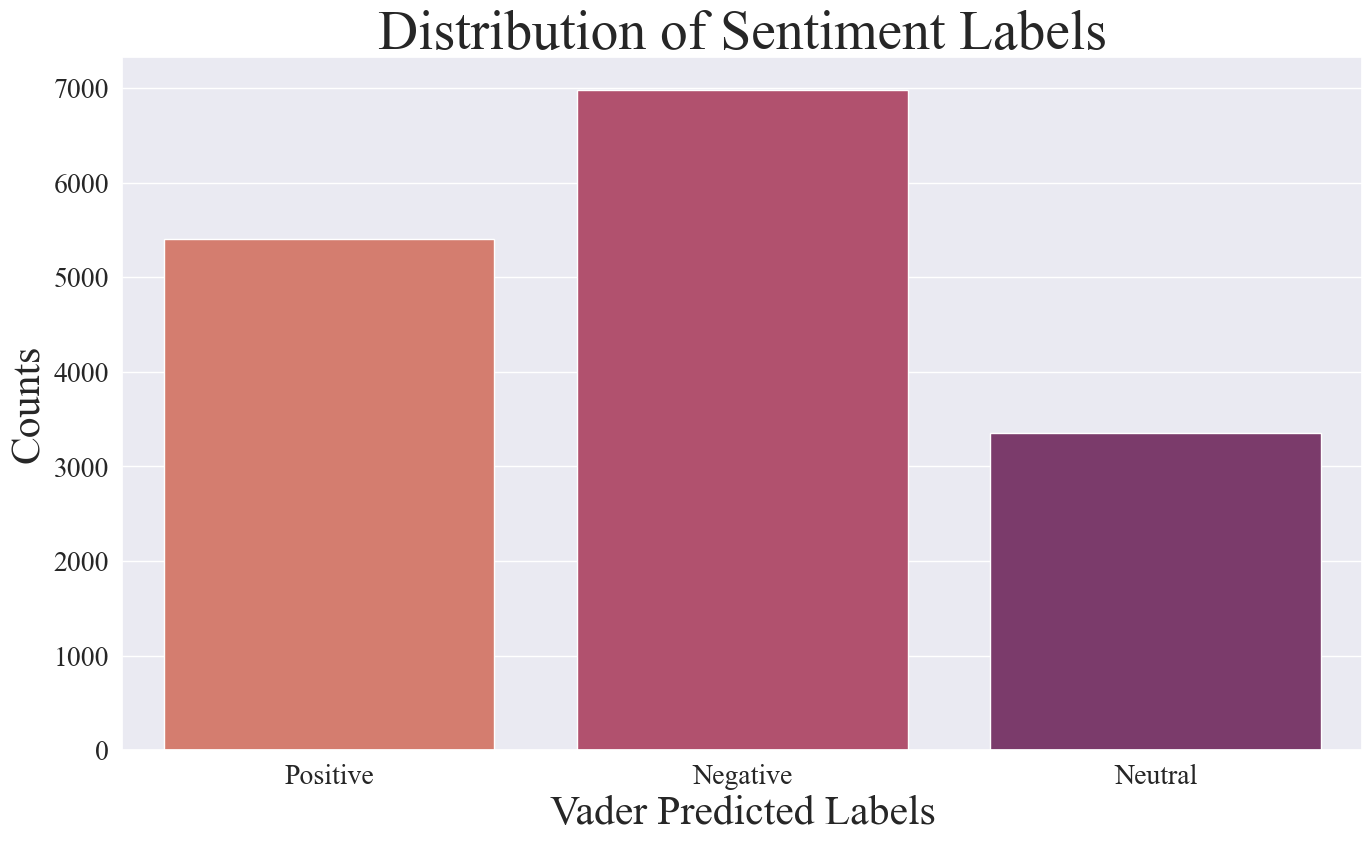

In [132]:

ZX_barplot(dataframe          =  df_cleaned_1_analysis_counts                ,
           x                  =  "Vader_sentiment"                           ,
           y                  =  "Counts"                                    ,
           #stat              =  "percent"                                   ,
           #multiple          =  "dodge"                                     ,
           palette            =  sns.color_palette("flare", 
                                   n_colors = 3 )                            ,
           # height           =  9                                           ,
           # aspect           =  4/3                                         ,
           order              =  ["pos", "neg", "neu"]                       ,
           x_title            =  "Vader Predicted Labels"                    ,
           y_title            =  "Counts"                                    ,
           p_title            =  "Distribution of Sentiment Labels"          ,
           xticklabels        =  ["Positive", "Negative", "Neutral"]         ,
           output_file_header = "Part2_Distribution of Vader_sentiment "     ,
           rotation           = 0
          )

<br/>

## <font size="12"> &#11088; </font> Dataset #1 Analysis 




- (Predictions on Dataset #1 and Comparison to Vader Sentiments)
- XGBClassifier turns out to have performance better than LogReg and MLP.
- Raw Data file used in this analysis is **reddit_raw_ukraine_russia.csv**

<br/>



<br/>

## <font size="20"> &#8681; </font>  MLP Prediction (Dataset #1)


In [133]:
#====================================================================================================#
# Bag of Words
vectorizer       =  CountVectorizer()
X_data_bow       =  vectorizer.fit_transform(X_data)
Dataset_1_X_bow  =  vectorizer.transform( df_cleaned_1_analysis["cleaned_text"].values.tolist() )

#====================================================================================================#
# Bag of Words
selector                 = SelectKBest(chi2, k = 10000)
X_data_bow_selected      = selector.fit_transform(X_data_bow, y_data)
Dataset_1_X_bow_selected = selector.transform(Dataset_1_X_bow)


#====================================================================================================#
# Vectorizer - TF-IDF
vectorizer        = TfidfVectorizer()
X_data_tfidf      = vectorizer.fit_transform(X_data)
Dataset_1_X_tfidf = vectorizer.transform( df_cleaned_1_analysis["cleaned_text"].values.tolist() )
#--------------------------------------------------#
# Select feature using the same selector in Part 1. 
selector                   = SelectKBest(chi2, k = 10000 )
X_train_tfidf_selected     = selector.fit_transform(X_data_tfidf, y_data)
Dataset_1_X_tfidf_selected = selector.transform(Dataset_1_X_tfidf)

#====================================================================================================#
# Load MLP model trained earlier.
# 
batch_size = 5000
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = MulticlassClassification(num_feature  = 10000 , 
                                 num_class    = 2     ,
                                 hid_1        = 1024  ,
                                 hid_2        = 1024  ,
                                 hid_3        = 1024  ,
                                 drp_r        = 0.5   ,
                                 )
model.to(device)
model.load_state_dict(torch.load(Path("./Saving_Part_1_MLP_Dataset_0_TFIDF.pt")))
model.eval()



y_ts         = [0] * len(Dataset_1_X_tfidf_selected.toarray())
X_y_ts       = LoaderClass_LowRAM(list(Dataset_1_X_tfidf_selected.toarray()), y_ts)
test_loader  = data.DataLoader(X_y_ts, batch_size, False, collate_fn = X_y_ts.collate_fn)

Dataset_1_y_pred_list = []
score_list  = []
for one_x_y_group in test_loader:
    Dataset_1_X_tfidf_ = one_x_y_group["X_data"].float().to(device)
    y_pred = model(Dataset_1_X_tfidf_)
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
    Dataset_1_y_pred_list.append(y_pred_tags.cpu().numpy())
    score_list .append(y_pred_softmax.cpu().detach().numpy())
Dataset_1_y_pred_list = np.concatenate(Dataset_1_y_pred_list)
score_list  = np.concatenate(score_list)
proba_list  = [np.exp(scores[1])/(np.exp(scores[0])+np.exp(scores[1])) for scores in score_list]

Dataset_1_MLP_label_list = ["pos" if l == 1 else "neg" for l in Dataset_1_y_pred_list]
df_cleaned_1_analysis["MLP_sentiment"] = Dataset_1_MLP_label_list

#====================================================================================================#
# Based on the probability list, we are able to predict the labels for the dataset. 
# Use a threshold for predicting "neutral" labels.

threshold = 0.005


Dataset_1_MLP_label_adj_list = ["pos" if p > 1-threshold else "neg" if p < threshold else "neu"  for p in proba_list] #
df_cleaned_1_analysis["MLP_sentiment_neu"] = Dataset_1_MLP_label_adj_list

# sns.histplot(Dataset_1_MLP_label_adj_list)
# plt.show()





<br/>

## <font size="20"> &#8681; </font> Comparing Vader Prediction against MLP Prediction (Dataset #1)

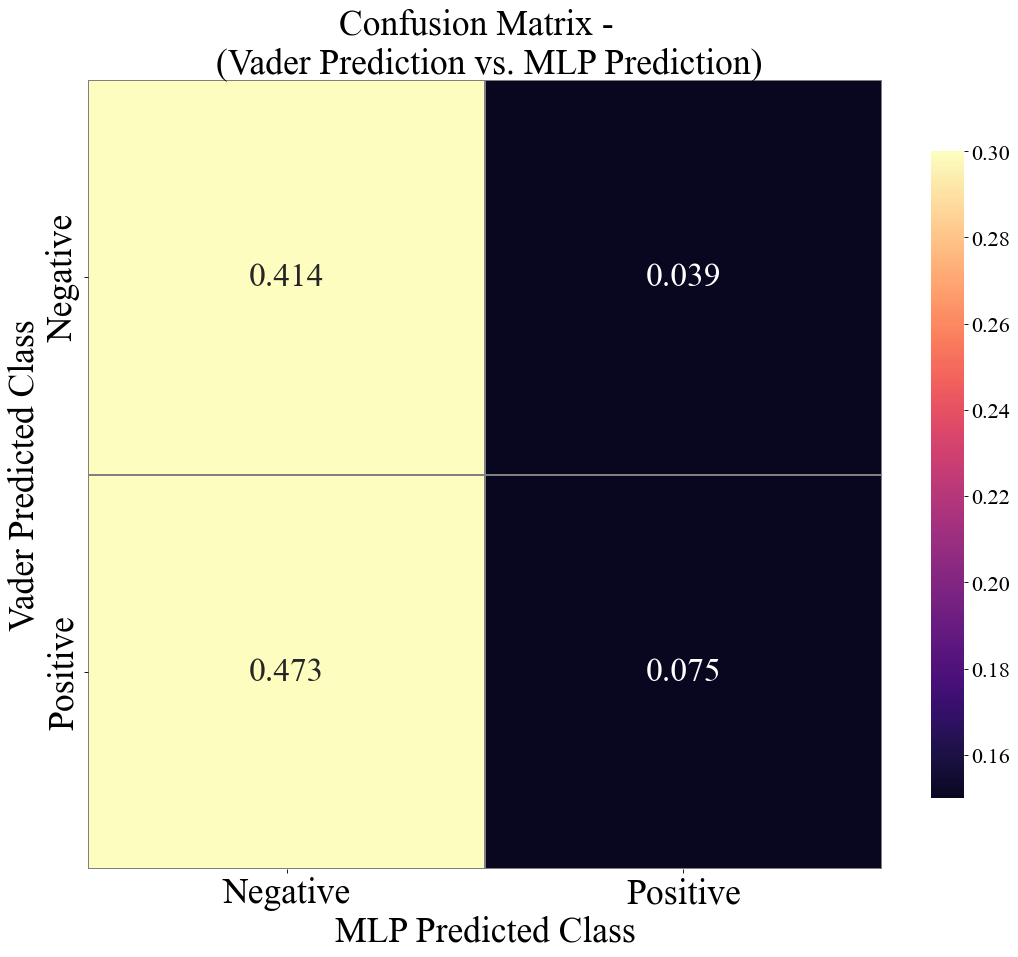

In [134]:
# Compare the two predictions.
num_classes = 2
output_file_header = "Part2"
plot_name = "Vader Prediction vs. MLP Prediction (Dataset #1)"
results_sub_folder = Path("Part2_Figures/")
MLP_sentiments_1   = df_cleaned_1_analysis["MLP_sentiment"].values.tolist()
Vader_sentiments_1 = df_cleaned_1_analysis["Vader_sentiment"].values.tolist()


#====================================================================================================#
# Percentage HeatMap
font = {'family' : "Times New Roman"}
plt.rc('font', **font)
#--------------------------------------------------#
cm = confusion_matrix(Vader_sentiments_1, MLP_sentiments_1)
cm = cm/len(Vader_sentiments_1) 
confusion_matrix_df = pd.DataFrame(cm) #.rename(columns=idx2class, index=idx2class)
#--------------------------------------------------#
fig = plt.figure(num=None, figsize=(16, 12.8), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(confusion_matrix_df, 
                    annot      = True             , 
                    fmt        = ".3f"            , 
                    cmap       = "magma"          , 
                    vmin       = 0.15             , 
                    vmax       = 0.30             , 
                    center     = 0.22             , 
                    cbar_kws   = {"shrink": .82}  , 
                    linewidths = 0.1              , 
                    linecolor  = 'gray'           , 
                    annot_kws  = {"fontsize": 30} , 
                    )

ax.set_xlabel('MLP Predicted Class', fontsize = 32)
ax.set_ylabel('Vader Predicted Class', fontsize = 32)
ax.set_title("Confusion Matrix - " \
            + " \n (Vader Prediction vs. MLP Prediction)", fontsize = 32)
ax.xaxis.set_ticklabels([["Negative", "Positive"][i] for i in range(num_classes)], fontsize = 32) 
ax.yaxis.set_ticklabels([["Negative", "Positive"][i] for i in range(num_classes)], fontsize = 32) 
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.show()
#--------------------------------------------------#
saving_name = output_file_header + "_HeatMapCM_" + plot_name +"_percentage.png"
saving_name = saving_name 
fig.savefig(results_sub_folder / saving_name , dpi = 1000 )
mpl.rcParams.update(mpl.rcParamsDefault)



<br/>

## <font size="20"> &#8681; </font> XGB Prediction and LogReg Prediction (Dataset #1)

In [135]:
#====================================================================================================#
# Bag of Words
vectorizer       =  CountVectorizer()
X_data_bow       =  vectorizer.fit_transform(X_data)
Dataset_1_X_bow  =  vectorizer.transform( df_cleaned_1_analysis["cleaned_text"].values.tolist() )

#====================================================================================================#
# Bag of Words
selector                 = SelectKBest(chi2, k = 1000)
X_data_bow_selected      = selector.fit_transform(X_data_bow, y_data)
Dataset_1_X_bow_selected = selector.transform(Dataset_1_X_bow)


#====================================================================================================#
# Vectorizer - TF-IDF
vectorizer        = TfidfVectorizer()
X_data_tfidf      = vectorizer.fit_transform(X_data)
Dataset_1_X_tfidf = vectorizer.transform( df_cleaned_1_analysis["cleaned_text"].values.tolist() )
#--------------------------------------------------#
# Select feature using the same selector in Part 1. 
selector                   = SelectKBest(chi2, k = 1000 )
X_train_tfidf_selected     = selector.fit_transform(X_data_tfidf, y_data)
Dataset_1_X_tfidf_selected = selector.transform(Dataset_1_X_tfidf)


#====================================================================================================#
# XGBClassifier.
Dataset_1_XGBClassifier_pred = Sentiment_Binary_Classifier_Part1.predict(Dataset_1_X_bow_selected)
Dataset_1_XGB_label_list = ["pos" if l ==1 else "neg" for l in Dataset_1_XGBClassifier_pred]
df_cleaned_1_analysis["XGB_sentiment"] = Dataset_1_XGB_label_list


#====================================================================================================#
# LogisticRegression.
Dataset_1_LogisticRegression_pred = Sentiment_Binary_Classifier_Part1_2.predict(Dataset_1_X_tfidf_selected)
Dataset_1_LgR_label_list = ["pos" if l ==1 else "neg" for l in Dataset_1_LogisticRegression_pred]
df_cleaned_1_analysis["LgR_sentiment"] = Dataset_1_LgR_label_list




<br/>

## <font size="20"> &#8681; </font> XGB Prediction VS. Vader Prediction (Dataset #1)

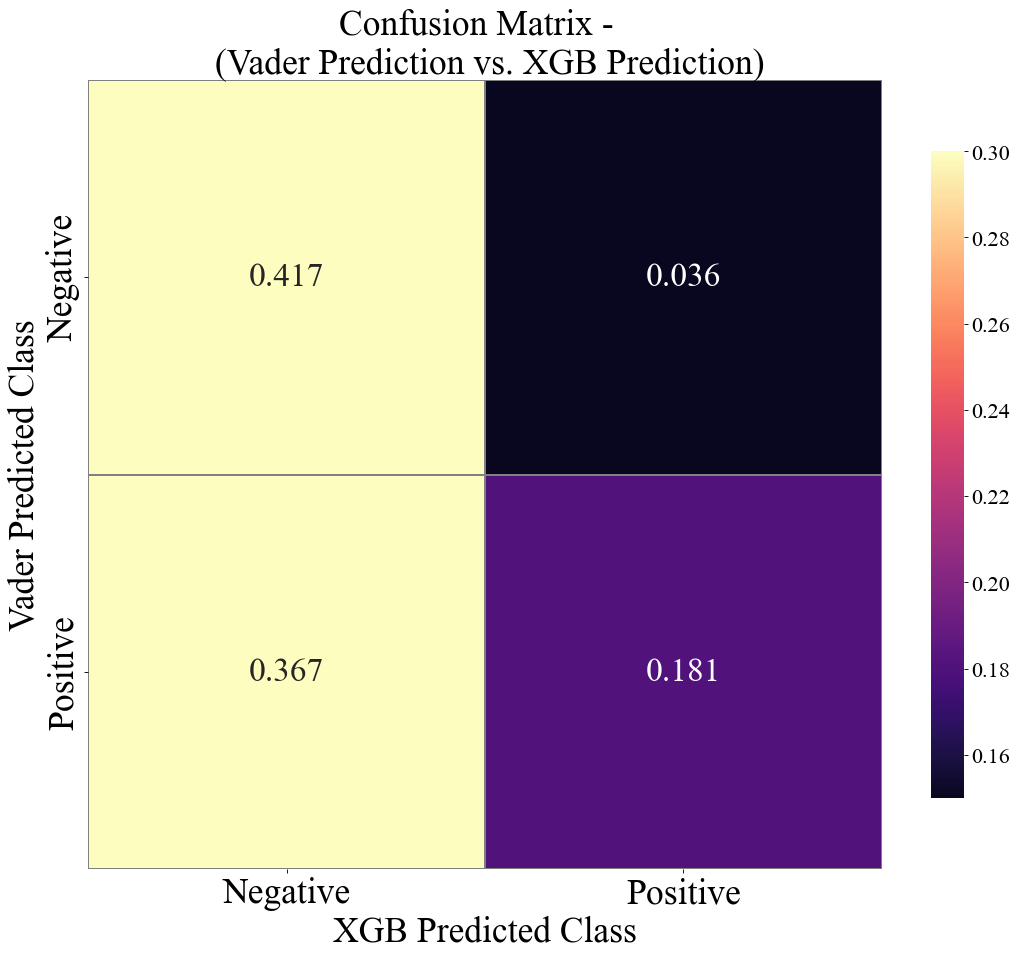

In [136]:
#====================================================================================================#
# Compare the two predictions.
num_classes = 2
output_file_header = "Part2"
plot_name = "Vader Prediction vs. XGB Prediction (Dataset #1)"
results_sub_folder = Path("Part2_Figures/")
XGB_sentiments_1   = df_cleaned_1_analysis["XGB_sentiment"].values.tolist()
Vader_sentiments_1 = df_cleaned_1_analysis["Vader_sentiment"].values.tolist()


#====================================================================================================#
# Percentage HeatMap
font = {'family' : "Times New Roman"}
plt.rc('font', **font)
#--------------------------------------------------#
cm = confusion_matrix(Vader_sentiments_1, XGB_sentiments_1)
cm = cm/len(Vader_sentiments_1) 
confusion_matrix_df = pd.DataFrame(cm) #.rename(columns=idx2class, index=idx2class)
#--------------------------------------------------#
fig = plt.figure(num=None, figsize=(16, 12.8), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(confusion_matrix_df, 
                    annot      = True             , 
                    fmt        = ".3f"            , 
                    cmap       = "magma"          , 
                    vmin       = 0.15             , 
                    vmax       = 0.30             , 
                    center     = 0.22             , 
                    cbar_kws   = {"shrink": .82}  , 
                    linewidths = 0.1              , 
                    linecolor  = 'gray'           , 
                    annot_kws  = {"fontsize": 30} , 
                    )

ax.set_xlabel('XGB Predicted Class', fontsize = 32)
ax.set_ylabel('Vader Predicted Class', fontsize = 32)
ax.set_title("Confusion Matrix - " \
            + " \n (Vader Prediction vs. XGB Prediction)", fontsize = 32)
ax.xaxis.set_ticklabels([["Negative", "Positive"][i] for i in range(num_classes)], fontsize = 32) 
ax.yaxis.set_ticklabels([["Negative", "Positive"][i] for i in range(num_classes)], fontsize = 32) 
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.show()
#--------------------------------------------------#
saving_name = output_file_header + "_HeatMapCM_" + plot_name +"_percentage.png"
saving_name = saving_name 
fig.savefig(results_sub_folder / saving_name , dpi = 1000 )
mpl.rcParams.update(mpl.rcParamsDefault)



<br/>

## <font size="20"> &#8681; </font> LgR Prediction VS. Vader Prediction (Dataset #1)

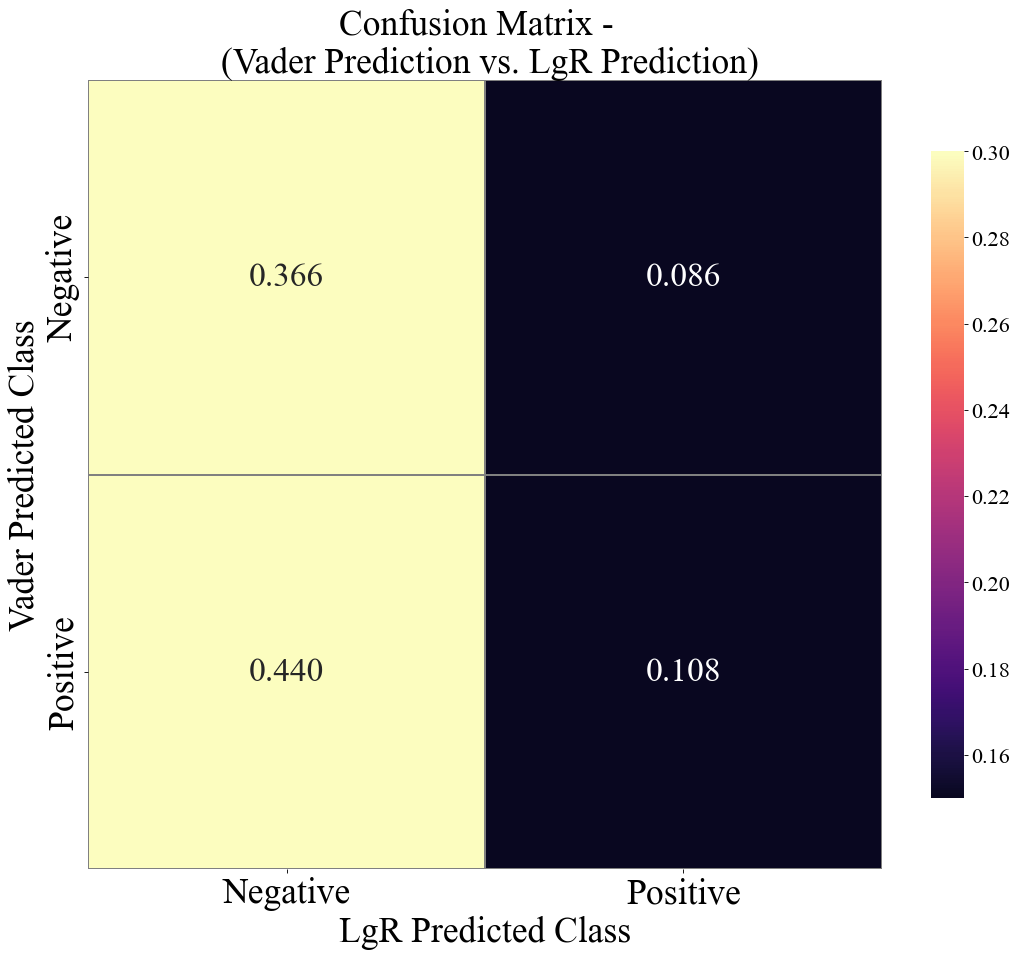

In [137]:
#====================================================================================================#
# Compare the two predictions.
num_classes = 2
output_file_header = "Part2"
plot_name = "Vader Prediction vs. LgR Prediction (Dataset #1)"
results_sub_folder = Path("Part2_Figures/")
LgR_sentiments_1   = df_cleaned_1_analysis["LgR_sentiment"].values.tolist()
Vader_sentiments_1 = df_cleaned_1_analysis["Vader_sentiment"].values.tolist()


#====================================================================================================#
# Percentage HeatMap
font = {'family' : "Times New Roman"}
plt.rc('font', **font)
#--------------------------------------------------#
cm = confusion_matrix(Vader_sentiments_1, LgR_sentiments_1)
cm = cm/len(Vader_sentiments_1) 
confusion_matrix_df = pd.DataFrame(cm) #.rename(columns=idx2class, index=idx2class)
#--------------------------------------------------#
fig = plt.figure(num=None, figsize=(16, 12.8), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(confusion_matrix_df, 
                    annot      = True             , 
                    fmt        = ".3f"            , 
                    cmap       = "magma"          , 
                    vmin       = 0.15             , 
                    vmax       = 0.30             , 
                    center     = 0.22             , 
                    cbar_kws   = {"shrink": .82}  , 
                    linewidths = 0.1              , 
                    linecolor  = 'gray'           , 
                    annot_kws  = {"fontsize": 30} , 
                    )

ax.set_xlabel('LgR Predicted Class', fontsize = 32)
ax.set_ylabel('Vader Predicted Class', fontsize = 32)
ax.set_title("Confusion Matrix - " \
            + " \n (Vader Prediction vs. LgR Prediction)", fontsize = 32)
ax.xaxis.set_ticklabels([["Negative", "Positive"][i] for i in range(num_classes)], fontsize = 32) 
ax.yaxis.set_ticklabels([["Negative", "Positive"][i] for i in range(num_classes)], fontsize = 32) 
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.show()
#--------------------------------------------------#
saving_name = output_file_header + "_HeatMapCM_" + plot_name +"_percentage.png"
saving_name = saving_name 
fig.savefig(results_sub_folder / saving_name , dpi = 1000 )
mpl.rcParams.update(mpl.rcParamsDefault)



<br/>

## <font size="20"> &#8681; </font> Report Point-Biserial Correlation Coefficient (Dataset #1)

In [151]:
from scipy.stats import pointbiserialr

# Calculate the Point-Biserial correlation coefficient. 
MLP_sentiments_1   = df_cleaned_1_analysis["MLP_sentiment"  ].values.tolist()
XGB_sentiments_1   = df_cleaned_1_analysis["XGB_sentiment"  ].values.tolist()
LgR_sentiments_1   = df_cleaned_1_analysis["LgR_sentiment"  ].values.tolist()
Vader_sentiments_1 = df_cleaned_1_analysis["Vader_sentiment"].values.tolist()

MLP_sentiments_binary_1   = [1 if l == "pos" else 0 for l in MLP_sentiments_1  ] 
XGB_sentiments_binary_1   = [1 if l == "pos" else 0 for l in XGB_sentiments_1  ]
LgR_sentiments_binary_1   = [1 if l == "pos" else 0 for l in LgR_sentiments_1  ]
Vader_sentiments_binary_1 = [1 if l == "pos" else 0 for l in Vader_sentiments_1]

biserialrcorr, p_value = pointbiserialr(Vader_sentiments_binary, XGB_sentiments_binary)   # 0.3034
# biserialrcorr, p_value = pointbiserialr(Vader_sentiments_binary, MLP_sentiments_binary) # 0.0825
# biserialrcorr, p_value = pointbiserialr(Vader_sentiments_binary, LgR_sentiments_binary) # 0.0085



print("Best-performed model we trained are XGBClassifier. ")
print("Point-Biserial correlation coefficient:", biserialrcorr)
print("p-value:", p_value)
print(f"{np.round(accuracy_score(XGB_sentiments_1, Vader_sentiments_1) * 100, 2)}% of the predictions are same as Vader Prediction.")



Best-performed model we trained are XGBClassifier. 
Point-Biserial correlation coefficient: 0.303444775379853
p-value: 0.0
59.73% of the predictions are same as Vader Prediction.




<br/>

## <font size="20"> &#8681; </font> Comparing number of different labels predicted (Dataset #1)

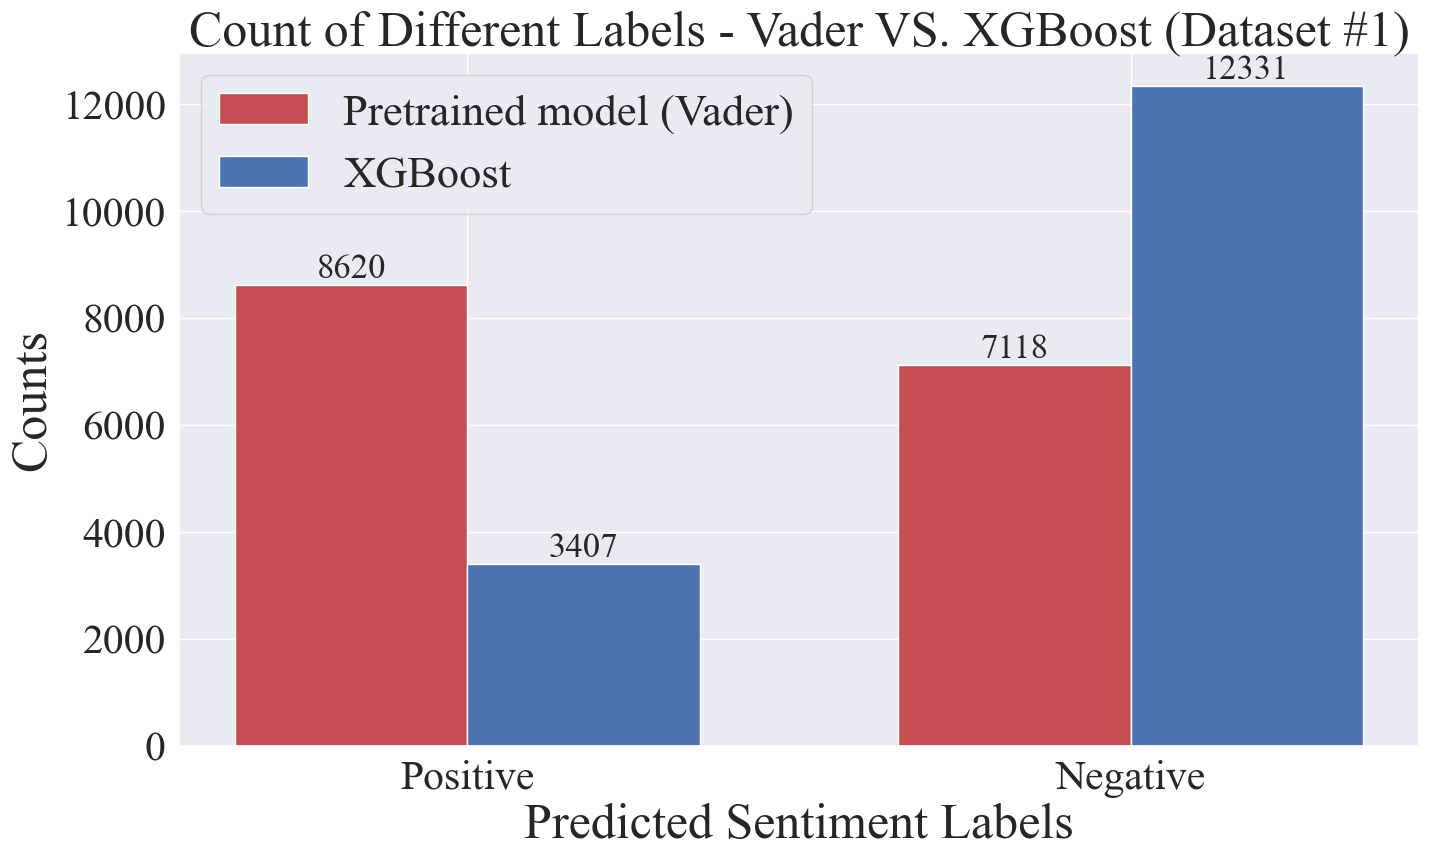

In [139]:
# Will format this figure later. 

labels = ['Positive', 'Negative']
values1 = [len([x for x in Vader_sentiments_binary_1   if x == 1]), 
           len([x for x in Vader_sentiments_binary_1   if x == 0])]
values2 = [len([x for x in   XGB_sentiments_binary_1   if x == 1]),
           len([x for x in   XGB_sentiments_binary_1   if x == 0])]


# Show the model performance test set.
#--------------------------------------------------#
sns.set(style = "darkgrid")
fig = plt.figure(figsize=(16,9))
#--------------------------------------------------#
font = {'family' : "Times New Roman"}
plt.rc('font', **font)
mpl.rc('font', family = 'serif', serif = "Times New Roman")
#--------------------------------------------------#
width = 0.35

ax1 = plt.bar(labels, values1, width, label='Pretrained model (Vader)', color = "r")
ax2 = plt.bar([i + width for i in range(len(values2))], values2, width, label='XGBoost')

plt.bar_label(ax1, fontsize = 25)
plt.bar_label(ax2, fontsize = 25)


plt.xlabel('Predicted Sentiment Labels')
plt.ylabel('Count')

plt.xticks(np.arange(2) + 0.175,labels)

plt.legend()

#--------------------------------------------------#
plt.rc('font', **font)
plt.rc('font', size = 30)             # controls default text sizes
plt.rc('axes', titlesize = 30)        # fontsize of the axes title
plt.rc('axes', labelsize = 30)        # fontsize of the x and y labels

plt.rc('xtick',  labelsize = 30, )    # fontsize of the tick labels
plt.rc('ytick',  labelsize = 30, )    # fontsize of the tick labels
plt.rc('legend', fontsize = 30,  )    # legend fontsize
plt.rc('figure', titlesize = 30, )    # fontsize of the figure title

plt.xticks(fontsize = 30, **font)
plt.yticks(fontsize = 30, **font)


plt.xlabel('Predicted Sentiment Labels'  , fontsize = 36, **font)
plt.ylabel('Counts'                      , fontsize = 36, **font)
plt.title ('Count of Different Labels - Vader VS. XGBoost (Dataset #1)' , 
            fontsize = 36, **font)

plt.legend(fontsize='32', )

plt.rc('font', **font)
mpl.rc('font', family = 'serif', serif = "Times New Roman")

saving_folder    =  Path("Part2_Figures")
saving_file_name =  "Part2_" + "Count of Different Labels - Vader VS. XGBoost (Dataset #1).png"

#--------------------------------------------------#
plt.savefig( saving_folder / saving_file_name, transparent = False)
plt.show()


<br/>

## <font size="12"> &#11088; </font> Dataset #2 Analysis 

- (Predictions on Dataset #2 and Comparison to Vader Sentiments)
- XGBClassifier turns out to have performance better than LogReg and MLP.
- Raw data file used in this analysis is **russian_invasion_of_ukraine.csv**




<br/>

## <font size="20"> &#8681; </font>  MLP Prediction (Dataset #2)


In [140]:
#====================================================================================================#
# Bag of Words
vectorizer       =  CountVectorizer()
X_data_bow       =  vectorizer.fit_transform(X_data)
Dataset_2_X_bow  =  vectorizer.transform( df_cleaned_2_analysis["cleaned_text"].values.tolist() )

#====================================================================================================#
# Bag of Words
selector                 = SelectKBest(chi2, k = 10000)
X_data_bow_selected      = selector.fit_transform(X_data_bow, y_data)
Dataset_2_X_bow_selected = selector.transform(Dataset_2_X_bow)


#====================================================================================================#
# Vectorizer - TF-IDF
vectorizer        = TfidfVectorizer()
X_data_tfidf      = vectorizer.fit_transform(X_data)
Dataset_2_X_tfidf = vectorizer.transform( df_cleaned_2_analysis["cleaned_text"].values.tolist() )
#--------------------------------------------------#
# Select feature using the same selector in Part 1. 
selector                   = SelectKBest(chi2, k = 10000 )
X_train_tfidf_selected     = selector.fit_transform(X_data_tfidf, y_data)
Dataset_2_X_tfidf_selected = selector.transform(Dataset_2_X_tfidf)

#====================================================================================================#
# Load MLP model trained earlier.
# 
batch_size = 5000
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = MulticlassClassification(num_feature  = 10000 , 
                                 num_class    = 2     ,
                                 hid_1        = 1024  ,
                                 hid_2        = 1024  ,
                                 hid_3        = 1024  ,
                                 drp_r        = 0.5   ,
                                 )
model.to(device)
model.load_state_dict(torch.load(Path("./Saving_Part_1_MLP_Dataset_0_TFIDF.pt")))
model.eval()



y_ts         = [0] * len(Dataset_2_X_tfidf_selected.toarray())
X_y_ts       = LoaderClass_LowRAM(list(Dataset_2_X_tfidf_selected.toarray()), y_ts)
test_loader  = data.DataLoader(X_y_ts, batch_size, False, collate_fn = X_y_ts.collate_fn)

Dataset_2_y_pred_list = []
score_list  = []
for one_x_y_group in test_loader:
    Dataset_2_X_tfidf_ = one_x_y_group["X_data"].float().to(device)
    y_pred = model(Dataset_2_X_tfidf_)
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
    Dataset_2_y_pred_list.append(y_pred_tags.cpu().numpy())
    score_list .append(y_pred_softmax.cpu().detach().numpy())
Dataset_2_y_pred_list = np.concatenate(Dataset_2_y_pred_list)
score_list  = np.concatenate(score_list)
proba_list  = [np.exp(scores[1])/(np.exp(scores[0])+np.exp(scores[1])) for scores in score_list]

Dataset_2_MLP_label_list = ["pos" if l == 1 else "neg" for l in Dataset_2_y_pred_list]
df_cleaned_2_analysis["MLP_sentiment"] = Dataset_2_MLP_label_list

#====================================================================================================#
# Based on the probability list, we are able to predict the labels for the dataset. 
# Use a threshold for predicting "neutral" labels.

threshold = 0.005


Dataset_2_MLP_label_adj_list = ["pos" if p > 1-threshold else "neg" if p < threshold else "neu"  for p in proba_list] #
df_cleaned_2_analysis["MLP_sentiment_neu"] = Dataset_2_MLP_label_adj_list

# sns.histplot(Dataset_2_MLP_label_adj_list)
# plt.show()





<br/>

## <font size="20"> &#8681; </font> Comparing Vader Prediction against MLP Prediction (Dataset #2)

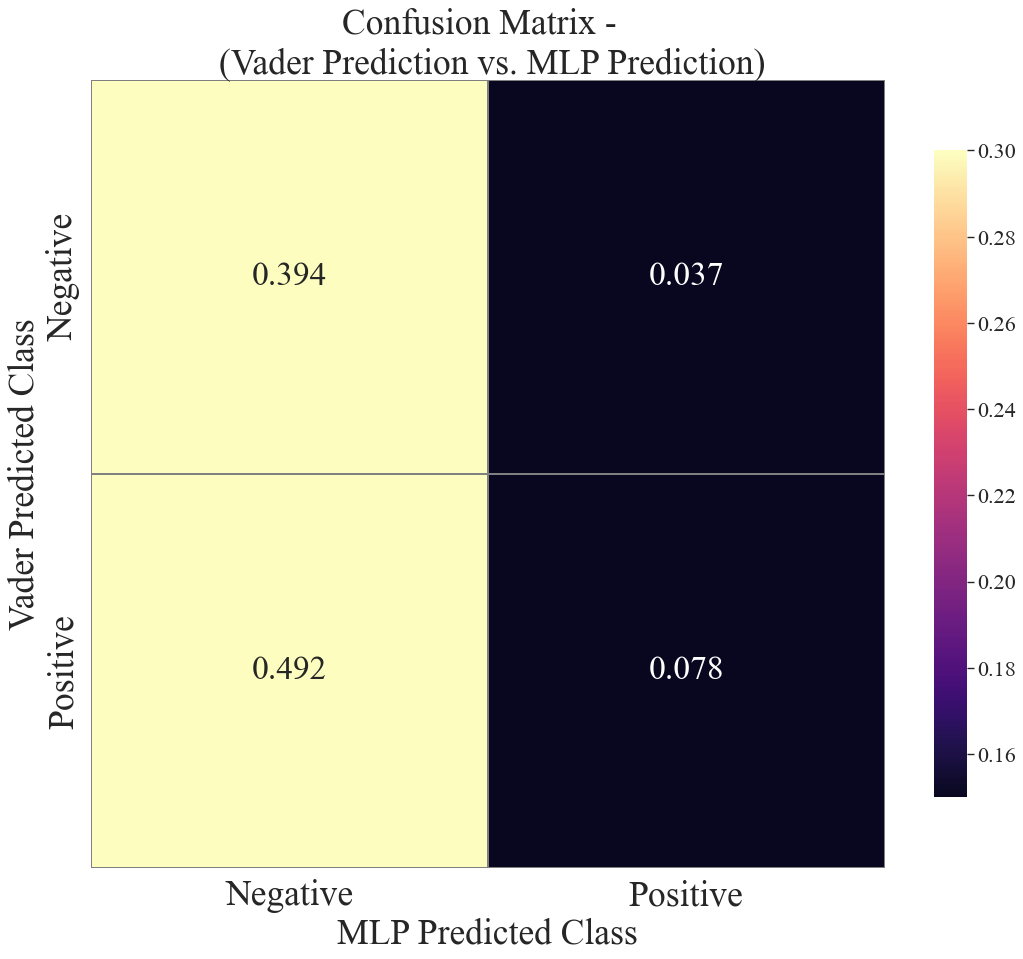

In [141]:
# Compare the two predictions.
num_classes = 2
output_file_header = "Part2"
plot_name = "Vader Prediction vs. MLP Prediction (Dataset #2)"
results_sub_folder = Path("Part2_Figures/")
MLP_sentiments_2   = df_cleaned_2_analysis["MLP_sentiment"].values.tolist()
Vader_sentiments_2 = df_cleaned_2_analysis["Vader_sentiment"].values.tolist()


#====================================================================================================#
# Percentage HeatMap
font = {'family' : "Times New Roman"}
plt.rc('font', **font)
#--------------------------------------------------#
cm = confusion_matrix(Vader_sentiments_2, MLP_sentiments_2)
cm = cm/len(Vader_sentiments_2) 
confusion_matrix_df = pd.DataFrame(cm) #.rename(columns=idx2class, index=idx2class)
#--------------------------------------------------#
fig = plt.figure(num=None, figsize=(16, 12.8), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(confusion_matrix_df, 
                    annot      = True             , 
                    fmt        = ".3f"            , 
                    cmap       = "magma"          , 
                    vmin       = 0.15             , 
                    vmax       = 0.30             , 
                    center     = 0.22             , 
                    cbar_kws   = {"shrink": .82}  , 
                    linewidths = 0.1              , 
                    linecolor  = 'gray'           , 
                    annot_kws  = {"fontsize": 30} , 
                    )

ax.set_xlabel('MLP Predicted Class', fontsize = 32)
ax.set_ylabel('Vader Predicted Class', fontsize = 32)
ax.set_title("Confusion Matrix - " \
            + " \n (Vader Prediction vs. MLP Prediction)", fontsize = 32)
ax.xaxis.set_ticklabels([["Negative", "Positive"][i] for i in range(num_classes)], fontsize = 32) 
ax.yaxis.set_ticklabels([["Negative", "Positive"][i] for i in range(num_classes)], fontsize = 32) 
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.show()
#--------------------------------------------------#
saving_name = output_file_header + "_HeatMapCM_" + plot_name +"_percentage.png"
saving_name = saving_name 
fig.savefig(results_sub_folder / saving_name , dpi = 1000 )
mpl.rcParams.update(mpl.rcParamsDefault)



<br/>

## <font size="20"> &#8681; </font> XGB Prediction and LogReg Prediction (Dataset #2)

In [142]:
#====================================================================================================#
# Bag of Words
vectorizer       =  CountVectorizer()
X_data_bow       =  vectorizer.fit_transform(X_data)
Dataset_2_X_bow  =  vectorizer.transform( df_cleaned_2_analysis["cleaned_text"].values.tolist() )

#====================================================================================================#
# Bag of Words
selector                 = SelectKBest(chi2, k = 1000)
X_data_bow_selected      = selector.fit_transform(X_data_bow, y_data)
Dataset_2_X_bow_selected = selector.transform(Dataset_2_X_bow)


#====================================================================================================#
# Vectorizer - TF-IDF
vectorizer        = TfidfVectorizer()
X_data_tfidf      = vectorizer.fit_transform(X_data)
Dataset_2_X_tfidf = vectorizer.transform( df_cleaned_2_analysis["cleaned_text"].values.tolist() )
#--------------------------------------------------#
# Select feature using the same selector in Part 1. 
selector                   = SelectKBest(chi2, k = 1000 )
X_train_tfidf_selected     = selector.fit_transform(X_data_tfidf, y_data)
Dataset_2_X_tfidf_selected = selector.transform(Dataset_2_X_tfidf)


#====================================================================================================#
# XGBClassifier.
Dataset_2_XGBClassifier_pred = Sentiment_Binary_Classifier_Part1.predict(Dataset_2_X_bow_selected)
Dataset_2_XGB_label_list = ["pos" if l ==1 else "neg" for l in Dataset_2_XGBClassifier_pred]
df_cleaned_2_analysis["XGB_sentiment"] = Dataset_2_XGB_label_list


#====================================================================================================#
# LogisticRegression.
Dataset_2_LogisticRegression_pred = Sentiment_Binary_Classifier_Part1_2.predict(Dataset_2_X_tfidf_selected)
Dataset_2_LgR_label_list = ["pos" if l ==1 else "neg" for l in Dataset_2_LogisticRegression_pred]
df_cleaned_2_analysis["LgR_sentiment"] = Dataset_2_LgR_label_list




<br/>

## <font size="20"> &#8681; </font> XGB Prediction VS. Vader Prediction (Dataset #2)

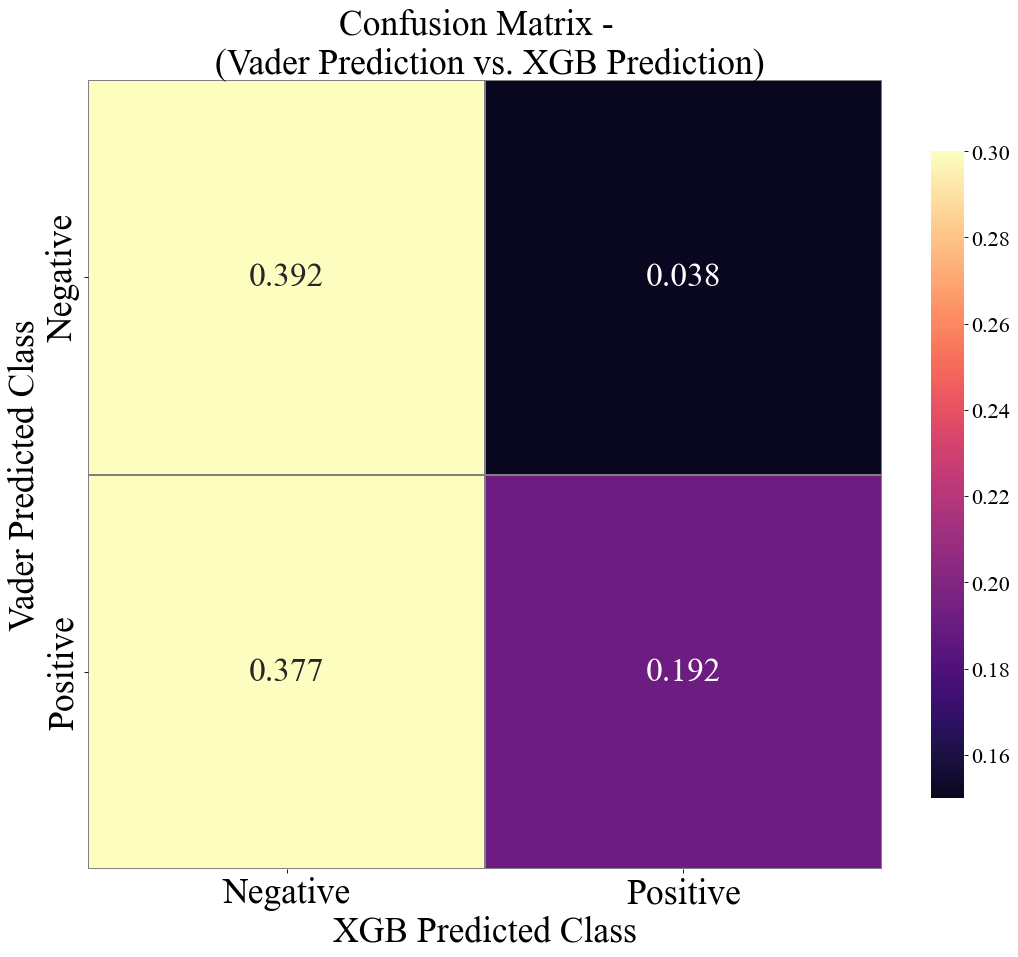

In [143]:
#====================================================================================================#
# Compare the two predictions.
num_classes = 2
output_file_header = "Part2"
plot_name = "Vader Prediction vs. XGB Prediction (Dataset #2)"
results_sub_folder = Path("Part2_Figures/")
XGB_sentiments_2   = df_cleaned_2_analysis["XGB_sentiment"].values.tolist()
Vader_sentiments_2 = df_cleaned_2_analysis["Vader_sentiment"].values.tolist()


#====================================================================================================#
# Percentage HeatMap
font = {'family' : "Times New Roman"}
plt.rc('font', **font)
#--------------------------------------------------#
cm = confusion_matrix(Vader_sentiments_2, XGB_sentiments_2)
cm = cm/len(Vader_sentiments_2) 
confusion_matrix_df = pd.DataFrame(cm) #.rename(columns=idx2class, index=idx2class)
#--------------------------------------------------#
fig = plt.figure(num=None, figsize=(16, 12.8), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(confusion_matrix_df, 
                    annot      = True             , 
                    fmt        = ".3f"            , 
                    cmap       = "magma"          , 
                    vmin       = 0.15             , 
                    vmax       = 0.30             , 
                    center     = 0.22             , 
                    cbar_kws   = {"shrink": .82}  , 
                    linewidths = 0.1              , 
                    linecolor  = 'gray'           , 
                    annot_kws  = {"fontsize": 30} , 
                    )

ax.set_xlabel('XGB Predicted Class', fontsize = 32)
ax.set_ylabel('Vader Predicted Class', fontsize = 32)
ax.set_title("Confusion Matrix - " \
            + " \n (Vader Prediction vs. XGB Prediction)", fontsize = 32)
ax.xaxis.set_ticklabels([["Negative", "Positive"][i] for i in range(num_classes)], fontsize = 32) 
ax.yaxis.set_ticklabels([["Negative", "Positive"][i] for i in range(num_classes)], fontsize = 32) 
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.show()
#--------------------------------------------------#
saving_name = output_file_header + "_HeatMapCM_" + plot_name +"_percentage.png"
saving_name = saving_name 
fig.savefig(results_sub_folder / saving_name , dpi = 1000 )
mpl.rcParams.update(mpl.rcParamsDefault)



<br/>

## <font size="20"> &#8681; </font> LgR Prediction VS. Vader Prediction (Dataset #2)

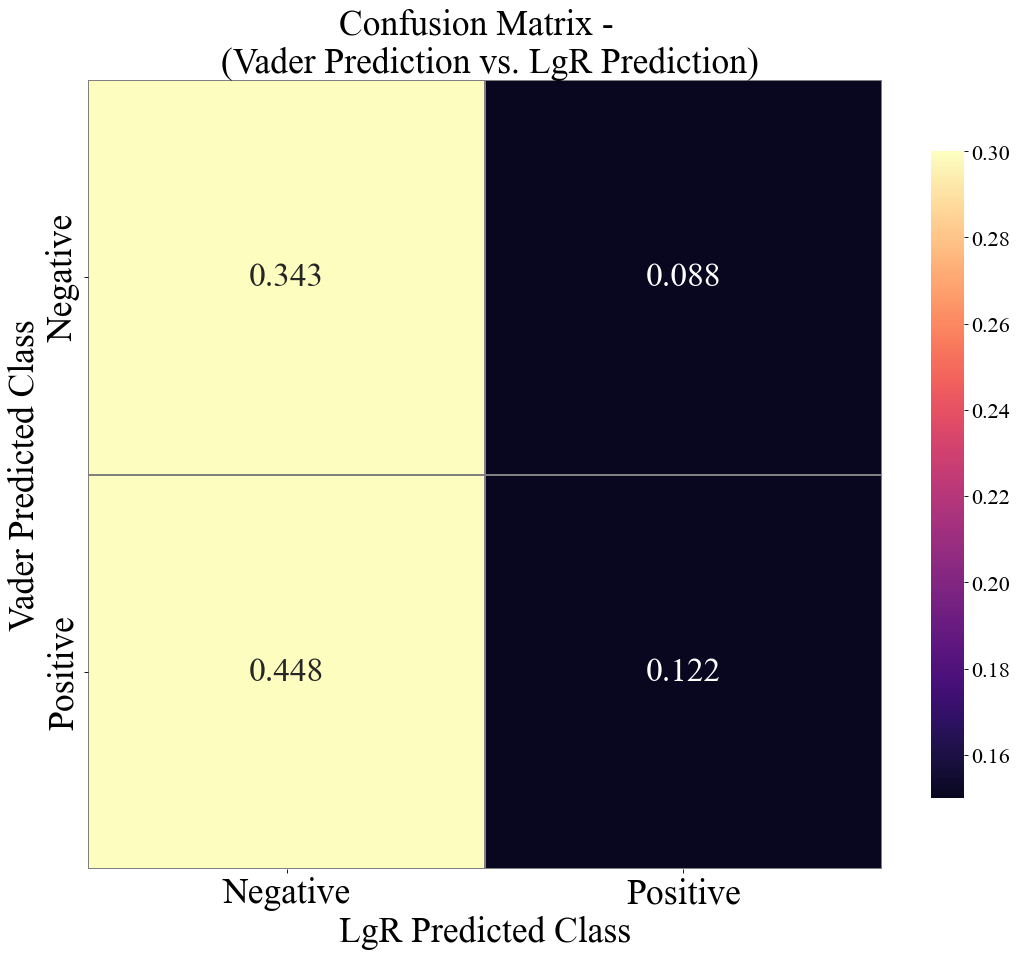

In [144]:
#====================================================================================================#
# Compare the two predictions.
num_classes = 2
output_file_header = "Part2"
plot_name = "Vader Prediction vs. LgR Prediction (Dataset #2)"
results_sub_folder = Path("Part2_Figures/")
LgR_sentiments_2   = df_cleaned_2_analysis["LgR_sentiment"].values.tolist()
Vader_sentiments_2 = df_cleaned_2_analysis["Vader_sentiment"].values.tolist()


#====================================================================================================#
# Percentage HeatMap
font = {'family' : "Times New Roman"}
plt.rc('font', **font)
#--------------------------------------------------#
cm = confusion_matrix(Vader_sentiments_2, LgR_sentiments_2)
cm = cm/len(Vader_sentiments_2) 
confusion_matrix_df = pd.DataFrame(cm) #.rename(columns=idx2class, index=idx2class)
#--------------------------------------------------#
fig = plt.figure(num=None, figsize=(16, 12.8), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(confusion_matrix_df, 
                    annot      = True             , 
                    fmt        = ".3f"            , 
                    cmap       = "magma"          , 
                    vmin       = 0.15             , 
                    vmax       = 0.30             , 
                    center     = 0.22             , 
                    cbar_kws   = {"shrink": .82}  , 
                    linewidths = 0.1              , 
                    linecolor  = 'gray'           , 
                    annot_kws  = {"fontsize": 30} , 
                    )

ax.set_xlabel('LgR Predicted Class', fontsize = 32)
ax.set_ylabel('Vader Predicted Class', fontsize = 32)
ax.set_title("Confusion Matrix - " \
            + " \n (Vader Prediction vs. LgR Prediction)", fontsize = 32)
ax.xaxis.set_ticklabels([["Negative", "Positive"][i] for i in range(num_classes)], fontsize = 32) 
ax.yaxis.set_ticklabels([["Negative", "Positive"][i] for i in range(num_classes)], fontsize = 32) 
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.show()
#--------------------------------------------------#
saving_name = output_file_header + "_HeatMapCM_" + plot_name +"_percentage.png"
saving_name = saving_name 
fig.savefig(results_sub_folder / saving_name , dpi = 1000 )
mpl.rcParams.update(mpl.rcParamsDefault)



<br/>

## <font size="20"> &#8681; </font> Report Point-Biserial Correlation Coefficient (Dataset #2)

In [145]:
from scipy.stats import pointbiserialr

# Calculate the Point-Biserial correlation coefficient. 
MLP_sentiments_2    = df_cleaned_2_analysis["MLP_sentiment"  ].values.tolist()
XGB_sentiments_2    = df_cleaned_2_analysis["XGB_sentiment"  ].values.tolist()
LgR_sentiments_2    = df_cleaned_2_analysis["LgR_sentiment"  ].values.tolist()
Vader_sentiments_2  = df_cleaned_2_analysis["Vader_sentiment"].values.tolist()


MLP_sentiments_binary_2   = [1 if l == "pos" else 0 for l in   MLP_sentiments_2]
XGB_sentiments_binary_2   = [1 if l == "pos" else 0 for l in   XGB_sentiments_2]
LgR_sentiments_binary_2   = [1 if l == "pos" else 0 for l in   LgR_sentiments_2]
Vader_sentiments_binary_2 = [1 if l == "pos" else 0 for l in Vader_sentiments_2]


biserialrcorr_2, p_value_2 = pointbiserialr(Vader_sentiments_binary_2, XGB_sentiments_binary_2)   # 0.292
# biserialrcorr_2, p_value_2 = pointbiserialr(Vader_sentiments_binary_2, LgR_sentiments_binary_2) # 0.0121
# biserialrcorr_2, p_value_2 = pointbiserialr(Vader_sentiments_binary_2, MLP_sentiments_binary_2) # 0.0808


print("Best-performed model we trained are XGBClassifier. ")
print("Point-Biserial correlation coefficient:", biserialrcorr_2)
print("p-value:", p_value_2)
print(f"{np.round(accuracy_score(XGB_sentiments_2, Vader_sentiments_2) * 100, 2)}% of the predictions are same as Vader Prediction.")




Best-performed model we trained are XGBClassifier. 
Point-Biserial correlation coefficient: 0.2926539361889905
p-value: 0.0
58.45% of the predictions are same as Vader Prediction.




<br/>

## <font size="20"> &#8681; </font> Comparing number of different labels predicted (Dataset #2)

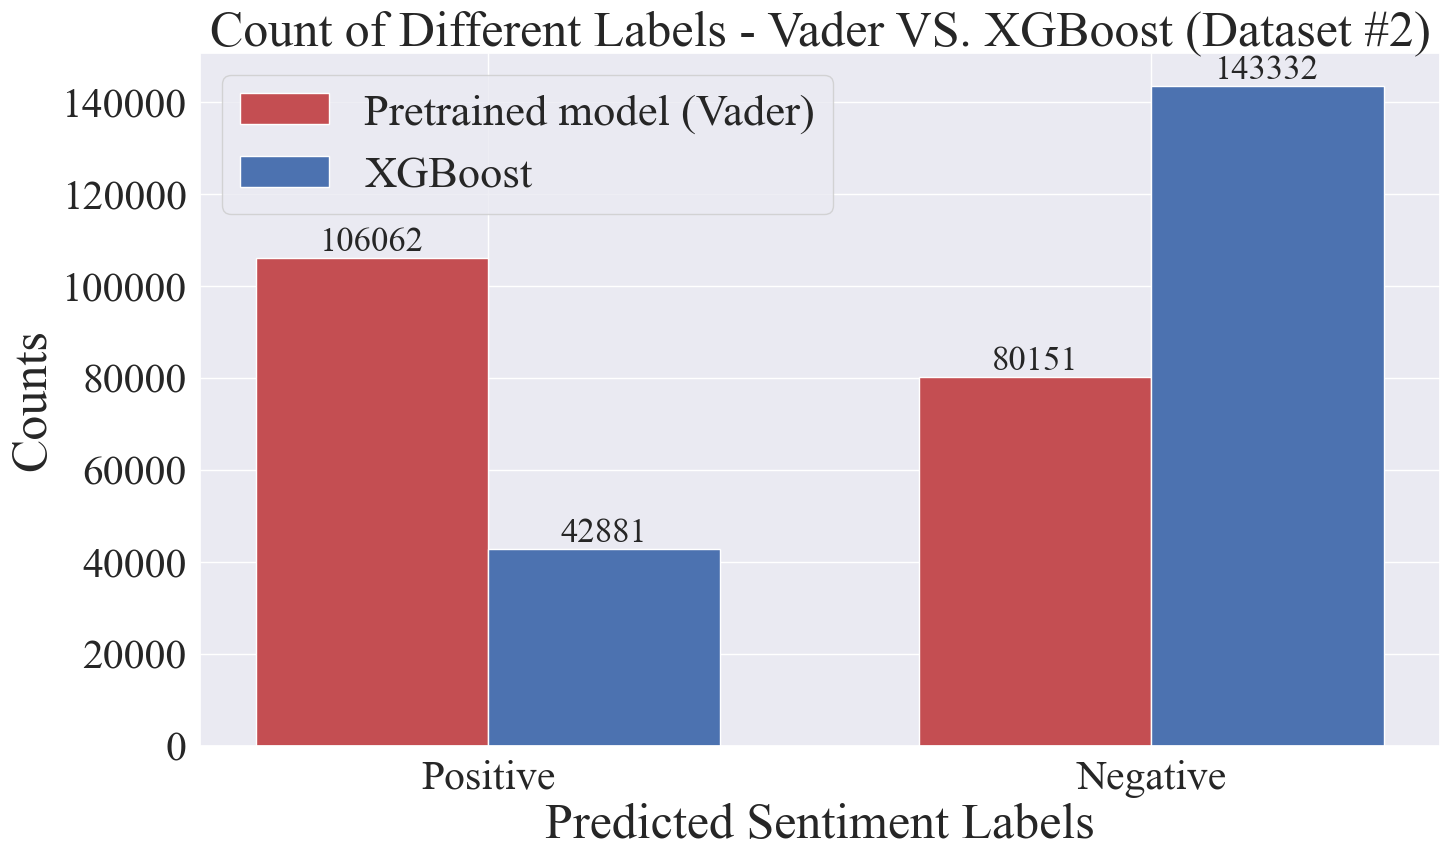

In [146]:


labels = ['Positive', 'Negative']
values1 = [len([x for x in Vader_sentiments_binary_2   if x == 1]), 
           len([x for x in Vader_sentiments_binary_2   if x == 0])]
values2 = [len([x for x in   XGB_sentiments_binary_2   if x == 1]),
           len([x for x in   XGB_sentiments_binary_2   if x == 0])]


# Show the model performance test set.
#--------------------------------------------------#
sns.set(style = "darkgrid")
fig = plt.figure(figsize=(16,9))
#--------------------------------------------------#
font = {'family' : "Times New Roman"}
plt.rc('font', **font)
mpl.rc('font', family = 'serif', serif = "Times New Roman")
#--------------------------------------------------#
width = 0.35

ax1 = plt.bar(labels, values1, width, label='Pretrained model (Vader)', color = "r")
ax2 = plt.bar([i + width for i in range(len(values2))], values2, width, label='XGBoost')

plt.bar_label(ax1, fontsize = 25)
plt.bar_label(ax2, fontsize = 25)


plt.xlabel('Predicted Sentiment Labels')
plt.ylabel('Count')

plt.xticks(np.arange(2)+0.175,labels)

plt.legend()

#--------------------------------------------------#
plt.rc('font', **font)
plt.rc('font', size = 30)             # controls default text sizes
plt.rc('axes', titlesize = 30)        # fontsize of the axes title
plt.rc('axes', labelsize = 30)        # fontsize of the x and y labels

plt.rc('xtick',  labelsize = 30, )    # fontsize of the tick labels
plt.rc('ytick',  labelsize = 30, )    # fontsize of the tick labels
plt.rc('legend', fontsize = 30,  )    # legend fontsize
plt.rc('figure', titlesize = 30, )    # fontsize of the figure title

plt.xticks(fontsize = 30, **font)
plt.yticks(fontsize = 30, **font)


plt.xlabel('Predicted Sentiment Labels'  , fontsize = 36, **font)
plt.ylabel('Counts'                      , fontsize = 36, **font)
plt.title ('Count of Different Labels - Vader VS. XGBoost (Dataset #2)' , 
            fontsize = 36, **font)

plt.legend(fontsize='32', )

plt.rc('font', **font)
mpl.rc('font', family = 'serif', serif = "Times New Roman")

saving_folder    =  Path("Part2_Figures")
saving_file_name =  "Part2_" + "Count of Different Labels - Vader VS. XGBoost (Dataset #2).png"

#--------------------------------------------------#
plt.savefig( saving_folder / saving_file_name, transparent = False)
plt.show()
